Referência para o pacote `survival`:
https://www.openintro.org/go/?id=survival_analysis_in_R&referrer=/stat/surv.php

In [ ]:
#Biblioteca resíduos cox:
install.packages('survminer')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘numDeriv’, ‘SparseM’, ‘MatrixModels’, ‘sp’, ‘minqa’, ‘nloptr’, ‘RcppEigen’, ‘carData’, ‘abind’, ‘pbkrtest’, ‘quantreg’, ‘maptools’, ‘lme4’, ‘bitops’, ‘Rcpp’, ‘corrplot’, ‘car’, ‘markdown’, ‘RCurl’, ‘png’, ‘jpeg’, ‘ggrepel’, ‘ggsci’, ‘cowplot’, ‘ggsignif’, ‘polynom’, ‘rstatix’, ‘exactRankTests’, ‘mvtnorm’, ‘KMsurv’, ‘zoo’, ‘km.ci’, ‘xtable’, ‘gridtext’, ‘ggpubr’, ‘gridExtra’, ‘maxstat’, ‘survMisc’, ‘ggtext’




In [ ]:
# Biblioteca para manipulacao de dados:
library(dplyr)

# Bibliotecas para analise de sobrevivencia:
library(survival)
library(survminer)

# Biblioteca para gráficos especificos:
library(ggplot2)


set.seed(2022)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: ggplot2

Loading required package: ggpubr


Attaching package: ‘survminer’


The following object is masked from ‘package:survival’:

    myeloma




# Dados


In [ ]:
# Carregamento dos Dados:
Path <- 'https://raw.githubusercontent.com/derSchmetterling'
Path <- paste0(Path, '/analise_sobrevivencia/main/Dados/18k_Projects.csv')
df <- read.csv2(Path, header=TRUE, sep="	")
glimpse(df)

Rows: 18,142
Columns: 35
$ Id                              <int> 1007121454, 2032015036, 733782855, 514…
$ Name                            <chr> "Nail Art and Photos Printed on your N…
$ Url                             <chr> "https://www.kickstarter.com/projects/…
$ State                           <chr> "failed", "failed", "failed", "failed"…
$ Currency                        <chr> "USD", "USD", "USD", "USD", "USD", "US…
$ Top.Category                    <chr> "Art", "Film & Video", "Fashion", "Pub…
$ Category                        <chr> "Art", "Short Film", "Fashion", "Poetr…
$ Creator                         <chr> "Dodie Egolf", "James Jacobs", "Uchu B…
$ Location                        <chr> "Puyallup", "Boston", "New York", "Det…
$ Updates                         <int> 0, 0, 1, 0, 0, 0, 5, 7, 9, 1, 4, 0, 0,…
$ Comments                        <int> 0, 0, 2, 0, 0, 0, 13, 33, 0, 0, 0, 0, …
$ Rewards                         <int> 9, 8, 17, 4, 12, 13, 21, 9, 30, 9, 4, …
$ Goal         

In [ ]:
# Removendo as linhas duplicadas -- Id:
n_occur <- data.frame(table(df$Id))
df <- df[df$Id %in% n_occur$Var1[n_occur$Freq == 1],]

# Removendo criadores que têm dois projetos:
n_occur <- data.frame(table(df$Creator))
df <- df[df$Creator %in% n_occur$Var1[n_occur$Freq == 1],]

dim(df)

[1] 16850    35

In [ ]:
# Selecionando apenas as colunas nas quais trabalharemos:
df <- df %>%
      select(duration = Duration.in.Days, censoring = State,
             shares = Facebook.Shares, facebook = Facebook.Connected,
             friends = Facebook.Friends)
glimpse(df)

Rows: 16,850
Columns: 5
$ duration  <int> 30, 33, 30, 60, 30, 40, 42, 40, 36, 31, 31, 30, 28, 60, 30, …
$ censoring <chr> "failed", "failed", "failed", "failed", "failed", "failed", …
$ shares    <int> 70, 57, 158, 2, 411, 142, 1960, 544, 1202, 110, 6, 185, 258,…
$ facebook  <chr> "Yes", "Yes", "No", "Yes", "Yes", "Yes", "No", "Yes", "Yes",…
$ friends   <int> 272, 573, NA, 1285, 969, 1566, NA, 104, 1284, 319, 537, 1499…


In [ ]:
# Tratando a censura:
df$censoring[df$censoring == 'failed'] <- 0
df$censoring[df$censoring == 'successful'] <- 1
df$censoring <- as.integer(df$censoring)

# Tratando a indicacao de conexao no facebook:
df$facebook[df$facebook == 'Yes'] <- 1
df$facebook[df$facebook == 'No'] <- 0
df$facebook <- as.factor(df$facebook)

# Trantando os NA's de amigos:
aux <- median(df$friends, na.rm=T)
df$friends[is.na(df$friends)] <- aux

# Ajeitando a escala das cov.'s amigos e compartilhamentos:
df$friends[df$friends == 0] <- 1
# é coerente assumir que os donos com "zero" amigos tenham pelo menos 1?
# Juan: acho que sim, todos têm um amigo!!
df$logF <- log(df$friends)

df$shares[df$shares == 0] <- 1
# é coerente assumir que "zero" compartilhamentos é um erro de registro?
# Juan: acho que sim tbm, os donos compartilhariam o próprio projeto!!
df$logS <- log(df$shares)

# Uma outra opção seria considerar que zero amigos ou
# compartilhamentos são casos anômalos e retirá-los.
# df[df$shares == 0.01 | df$friends == 0.01,] == 1285 casos


# Ordenando os tempos:
i <- order(df$duration)
df <- df[i,]

glimpse(df)

Rows: 16,850
Columns: 7
$ duration  <int> 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, …
$ censoring <int> 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, …
$ shares    <dbl> 7, 53, 2, 1, 3, 1, 23, 16, 23, 5, 57, 1, 73, 259, 6, 55, 66,…
$ facebook  <fct> 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, …
$ friends   <dbl> 1220, 1029, 229, 459, 1431, 173, 477, 915, 459, 665, 459, 30…
$ logF      <dbl> 7.106606, 6.936343, 5.433722, 6.129050, 7.266129, 5.153292, …
$ logS      <dbl> 1.9459101, 3.9702919, 0.6931472, 0.0000000, 1.0986123, 0.000…


# Modelo Paramétrico

Bom, essencialmente vamos fazer um modelo de regressão para o tempo até o evento (sucesso dos projetos) e, como visto em aula, eles normalmente são da forma:

$$\log{T} = Y = \beta_0 + \sum_{i=1}^d\beta_i X_i + \sigma \epsilon \\
  T = e^Y = \exp{(\beta_0 + \sum_{i=1}^d\beta_i X_i)} \exp{(\sigma \epsilon)}$$

Assim, para por exemplo, $\epsilon \sim N(0,1)$, têm-se $T \sim logN(X'\beta, \sigma^2)$. Outras distribuições famosas para os erros são: exponencial, weibull, logística e até a gama.

Porém, nossos dados são complicados e essas distribuições não se encaixam. Então tentaremos encontrar $m$ tal que $T \sim D_1(*)$ para $T \le m$ e $T \sim D_2(*)$ para $T \gt m$, i.e, os dados passam por um ponto crítico que muda os riscos e, consequentemente, a distribuição também ou pelos menos muda os valores dos parâmetros.

## Modelos com Ponto de Mudança

In [ ]:
ekm <- survfit(Surv(duration, censoring)~1, data=df)
t_f0 <- ekm$time # tempos de ocorrencia
s_f0 <- ekm$surv # valor da funcao de sobrevivencia
print(ekm)

Call: survfit(formula = Surv(duration, censoring) ~ 1, data = df)

         n events median 0.95LCL 0.95UCL
[1,] 16850   8451     34      34      34


Feito o modelo de Kaplan-Meier, vamos compará-lo com os modelos paramétricos usando as distribuições weibull e exponencial com ponto de mudança dos parâmetros.

### Weibull

Modelo de Sobrevivência Weibull com Ponto de Mudança:

$$\text{para}
\begin{cases}
T \sim W(\phi_1, \alpha_1), \text{ se T} \le m \\
T \sim W(\phi_2, \alpha_2), \text{ se T} \gt m
\end{cases}$$

Mas na verdade, vamos trabalhar com o logarítmo de T, por causa da convergência, assim, temos:

$$Y = log(T); \ \sigma = \frac{1}{\phi}; \ \mu = log(\alpha); \ p = log(m);$$

$$f_Y(y) = I\{y \le p\}f_{VE}(y|\mu_1, \sigma_1) + I\{y \gt p\}f_{EV}(y|\mu_2, \sigma_2) ;$$

$$S_Y(y) = \begin{cases} 1 - F_{VE}(y|\mu_1, \sigma_1), \text{ se y} \le p \\
1 - F_{VE}(p|\mu_1, \sigma_1) + F_{VE}(p|\mu_2,\sigma_2) - F_{VE}(y|\mu_2,\sigma_2), \text{ se y} \gt p;
\end{cases}$$

$$h_Y(y) = \frac{f_Y(y)}{S_Y(y)} \ e \ H_Y(y) = -log(S_Y(y))$$

em que $f_{VE}(y|\mu, \sigma) = \frac{1}{\sigma}exp(\frac{y-\mu}{\sigma} - exp(\frac{y-\mu}{\sigma}))$ e $F_{VE}(y|\mu,\sigma) = 1 - exp(-exp(\frac{y-\mu}{\sigma}))$. São respectivamente a densidade e a acumulada de uma variável com distribuição valor extremo.

$$ L(\mu_1, \sigma_1, \mu_2, \sigma_2, p| Y, c) = \prod_{i=1}^{n} [f_Y(y_i)]^{c_i} [S_Y(y_i)]^{1-c_i} \\
l(\mu_1, \sigma_1, \mu_2, \sigma_2, p) = \sum_{i=1}^n c_i log(f_Y(y_i)) + (1-c_i)log(S_Y(y_i))$$

Na verdade, podemos separar em dois produtórios e duas somas:

$$l(\mu_1, \sigma_1, \mu_2, \sigma_2, p) = \sum_{y_i \le p} c_i log(f_{VE}(y_i|\mu_1,\sigma_1)) + (1-c_i) log(S_Y(y_i)) + \sum_{y_j \gt p} c_j log(f_Y(y_j|\mu_2,\sigma_2)) + (1-c_j) log(S_Y(y_j))$$

In [ ]:
# função de distribuição da Valor Extremo com ponto de mudança:
dextvalPM <- function(y,p, mu1=0, sig1=1, mu2=1, sig2=1){
  if (y <= p){
    return( exp((y-mu1)/sig1 - exp((y-mu1)/sig1))/sig1 )
  } else {
    return( exp((y-mu2)/sig2 - exp((y-mu2)/sig2))/sig2 )
  }
}
dextvalPM <- Vectorize(dextvalPM)


# função acumulada da Valor Extremo com ponto de mudança:
pextvalPM <- function(y,p, mu1=0, sig1=1, mu2=0, sig2=1){
  if (y <= p){
    return( 1 - exp(-exp((y-mu1)/sig1)) )
  } else {
    aux = 1 - exp(-exp((p-mu1)/sig1))
    aux = aux + exp(-exp((p-mu2)/sig2))
    aux = aux - exp(-exp((y-mu2)/sig2))
    if (aux > 1) aux <- 1
    return( aux )
  }
}
pextvalPM <- Vectorize(pextvalPM)


# Log Verossimilhanca:
log.veros <- function(params, m, t, c){
  # constantes:
  p = log(m)
  mu1 = params[1]
  sig1 = params[2]
  mu2 = params[3]
  sig2 = params[4]

  y1 = log(t[t <= m]); y2 = 0
  c1 = c[t <= m]; c2 = 0
  if (m < max(t)) {
    y2 = log(t[t > m]); c2 = c[t > m]
  }
  # log(f1^c1)
  aux= sum( c1*log(dextvalPM(y1,p, mu1,sig1, mu2,sig2)) )
  # log(S1^(1-c1))
  aux= aux+ sum((1-c1)*log(1-pextvalPM(y1,p,mu1,sig1,mu2,sig2)))
  # log(f2^c2)
  aux= aux+ sum( c2*log(dextvalPM(y2,p, mu1,sig1, mu2,sig2)) )
  # log(S2^(1-c2))
  aux= aux+ sum((1-c2)*log(1-pextvalPM(y2,p,mu1,sig1,mu2,sig2)))
  return(aux)
}

Definidas todas as funções necessárias, vamos simular alguns valores dos parâmetros para diferentes valores iniciais e diferentes pontos de mudança.

In [ ]:
# definição de valores iniciais:
params <- matrix( c( 1, 1, 1, 1,
                    10,10,10,10,
                    10, 1,10, 1,
                     1,10, 1,10),
                 byrow=T, ncol=4)

# outputs:
omu1 = osig1 = omu2 = osig2  <- NULL
Vmu1 = Vsig1 = Vmu2 = Vsig2  <- NULL
pm <- NULL; veros <- NULL

options(warn=-1)
for (m in c(29,31,33)){
  for (i in 1:dim(params)[1]){
    out = optim(par=params[i,], # mu1, sigma1, mu2, sigma2 iniciais 
            fn = log.veros, # funcao a ser minimizada
            control=list(fnscale=-1), # dizendo que eh para minimizar
            hessian=T, #para conseguir a matrix de variancias-covariancias
            t=df$duration, c=df$censoring, m=m # constantes da funcao
    )
    omu1 <- c(omu1, out$par[1]); omu2 <- c(omu2, out$par[3])
    osig1 <- c(osig1, out$par[2]); osig2 <- c(osig2, out$par[4])

    vars <- diag(solve(-out$hessian))
    Vmu1 <- c(Vmu1, vars[1]); Vmu2 <- c(Vmu2, vars[3])
    Vsig1 <- c(Vsig1, vars[2]); Vsig2 <- c(Vsig2, vars[4])

    pm <- c(pm, m)
    veros <- c(veros, log.veros(out$par, m, df$duration, df$censoring))
  }
}
options(warn=0)

aux <- data.frame(pMUDANCA = pm,
                  MU1 = omu1, EPmu1 = Vmu1,
                  SIG1 = osig1, EPsig1 = Vsig1,
                  MU2 = omu2, EPmu2 = Vmu2,
                  SIG2 = osig2, EPsig2 = Vsig2,
                  logVeros = veros
)
print(aux, digits=4)

   pMUDANCA   MU1     EPmu1   SIG1    EPsig1   MU2      EPmu2   SIG2     EPsig2
1        29 3.747 6.953e-05 0.2699 2.189e-05 3.536  2.119e-05 0.3276  1.038e-05
2        29 3.731 7.207e-05 0.2528 1.746e-05 3.421  3.071e-05 0.3721  1.967e-05
3        29 3.747 6.962e-05 0.2701 2.196e-05 3.536  2.131e-05 0.3281  1.049e-05
4        29 3.957 4.078e-04 0.3556 8.767e-05 3.443  1.081e-05 0.2333  1.742e-06
5        31 3.524 5.393e-06 0.1511 3.099e-06 3.867  1.879e-03 0.6077  1.735e-04
6        31 3.517 4.540e-06 0.1395 2.277e-06 4.021  1.083e-03 0.5736  2.654e-04
7        31 3.457 2.969e-06 0.1721 6.628e-06 4.477  3.026e-04 0.5947  3.579e-04
8        31 3.527 5.660e-06 0.1531 3.271e-06 3.888  1.847e-03 0.6015  1.886e-04
9        33 3.557 7.254e-06 0.1890 5.644e-06 4.349  1.621e-04 0.4370  2.250e-04
10       33 3.556 6.142e-06 0.1704 3.609e-06 3.813  2.618e-03 0.7061  2.308e-04
11       33 3.515 3.929e-06 0.1870 5.479e-06 4.044 -1.261e-02 0.7846 -1.083e-03
12       33 3.557 6.156e-06 0.1711 3.652

In [ ]:
# Função de sobrevivência do Modelo Weibull com Ponto de Mudança:
sweiPM <- function(t, mu1, sig1, mu2, sig2, m){
  if (t <= m){
    return(1 - pweibull(t, 1/sig1, exp(mu1)))
    }
  else{
    aux = 1 + pweibull(m, 1/sig2, exp(mu2))
    aux = aux - pweibull(m, 1/sig1, exp(mu1))
    aux = aux - pweibull(t, 1/sig2, exp(mu2))
    return(aux)}
}
sweiPM <- Vectorize(sweiPM)

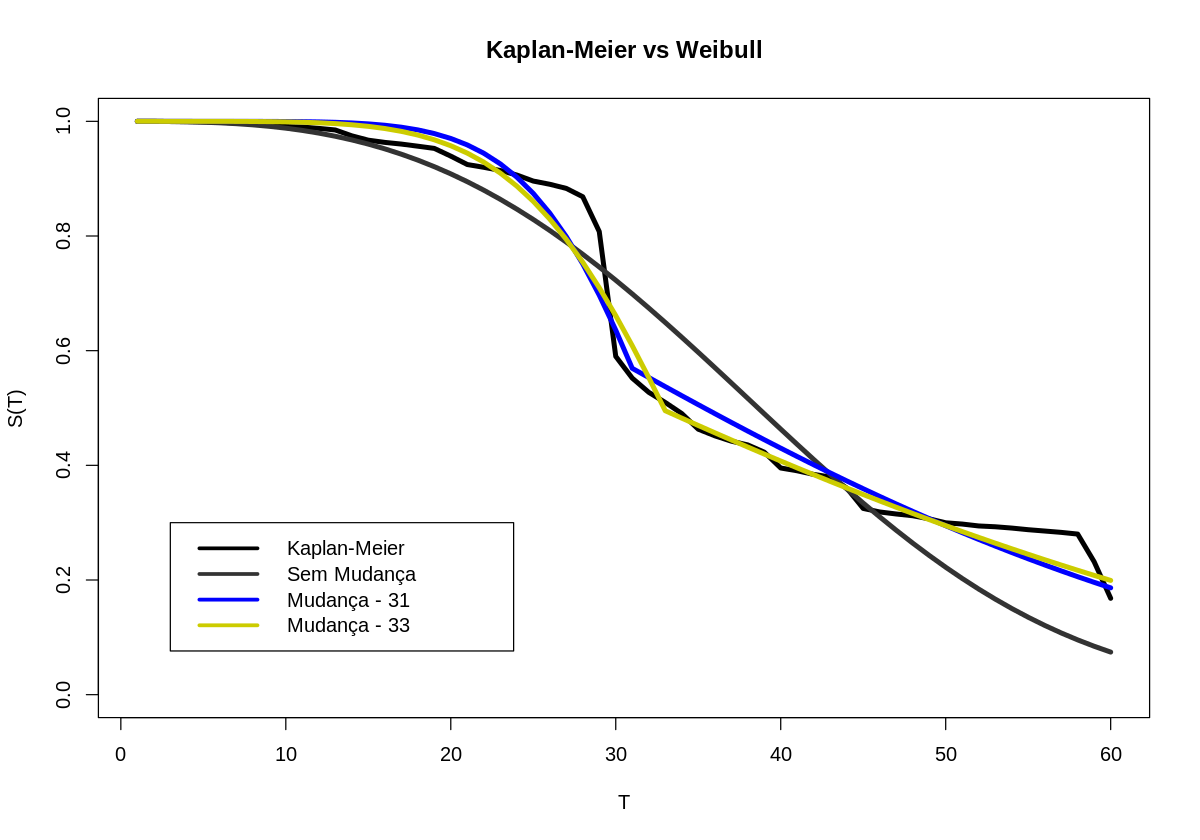

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 7)
# modelo weibull sem ponto de mudanca:
mWei <- survreg(Surv(duration, censoring)~1, data=df, dist='weibull')

plot(t_f0, s_f0, type='l', lwd=4, xlab='T', ylab='S(T)', ylim=c(0,1),
     main="Kaplan-Meier vs Weibull")
lines(1-pweibull(t_f0, 1/mWei$scale, exp(mWei$coefficients)),
      col='#333333', lwd=4, lty=1)

lines(sweiPM(t_f0, 3.52, 0.15, 3.87, 0.60, 31),
      col='blue', lwd=4, lty=1)
lines(sweiPM(t_f0, 3.56, 0.18, 4, 0.70, 33),
      col='#cccc00', lwd=4, lty=1)

legend(3, 0.30,
       c('Kaplan-Meier', 'Sem Mudança','Mudança - 31','Mudança - 33'),
       col=c('black', '#333333', 'blue', '#cccc00'),
       lwd=3, lty=1)

Vemos pelo gráfico que os modelos com o ponto de mudança em 31 e 33 são o que melhores se ajustam a curva de sobrevivência do modelo de Kaplan-Meier, sendo até mesmo melhores do que o modelo sem ponto de mudança.

### Exponencial

Dessa vez, vamos testar um modelo mais simples: o exponencial com ponto de mudança.

Na verdade, vamos aproveitar todas as funções feitas para o modelo weibull, apenas travar $\sigma_1 = \sigma_2 = 1$.

In [ ]:
# Log Verossimilhanca para Exponencial:
log.veros.ex <- function(params, m, t, c){
  aux = log.veros(c(params[1], 1, params[2], 1), m, t, c)
  return(aux)
}


# definição de valores iniciais:
params <- matrix( c(  1,  1,
                    100,100,
                    100,  1,
                      2,100),
                 byrow=T, ncol=2)

# outputs:
omu1 = omu2  <- NULL
Vmu1 = Vmu2 <- NULL
pm <- NULL; veros <- NULL

options(warn=-1)
for (m in 22:30){
  for (i in 1:dim(params)[1]){
    out = optim(par=params[i,], # mu1, sigma1, mu2, sigma2 iniciais 
            fn = log.veros.ex, # funcao a ser minimizada
            control=list(fnscale=-1), # dizendo que eh para minimizar
            hessian=T, #para conseguir a matrix de variancias-covariancias
            t=df$duration, c=df$censoring, m=m # constantes da funcao
    )
    omu1 <- c(omu1, out$par[1]); omu2 <- c(omu2, out$par[2])
    vars <- diag(solve(-out$hessian))
    Vmu1 <- c(Vmu1, vars[1]); Vmu2 <- c(Vmu2, vars[2])

    pm <- c(pm, m)
    veros <- c(veros, log.veros.ex(out$par, m, df$duration, df$censoring))
  }
}
options(warn=0)

aux2 <- data.frame(pMUDANCA = pm, MU1 = omu1, EPmu1 = Vmu1,
                   MU2 = omu2, EPmu2 = Vmu2, logVeros = veros)
print(aux2, digits=4)

   pMUDANCA   MU1     EPmu1   MU2     EPmu2  Veros
1        22 5.200 0.0007375 3.508 0.0001801 -13079
2        22 5.199 0.0007369 3.507 0.0001801 -13079
3        22 5.201 0.0007385 3.506 0.0001799 -13079
4        22 5.203 0.0007395 3.506 0.0001797 -13079
5        23 5.166 0.0006918 3.502 0.0001777 -13070
6        23 5.163 0.0006896 3.501 0.0001777 -13070
7        23 5.167 0.0006929 3.502 0.0001778 -13070
8        23 5.167 0.0006928 3.502 0.0001777 -13070
9        24 5.112 0.0006349 3.501 0.0001772 -13102
10       24 5.112 0.0006348 3.501 0.0001772 -13102
11       24 5.114 0.0006362 3.500 0.0001771 -13102
12       24 5.114 0.0006360 3.500 0.0001770 -13102
13       25 5.045 0.0005729 3.501 0.0001781 -13174
14       25 5.045 0.0005729 3.502 0.0001782 -13174
15       25 5.047 0.0005737 3.502 0.0001782 -13174
16       25 5.047 0.0005739 3.502 0.0001783 -13174
17       26 5.021 0.0005457 3.500 0.0001766 -13170
18       26 5.022 0.0005460 3.498 0.0001763 -13170
19       26 5.022 0.0005460 3.4

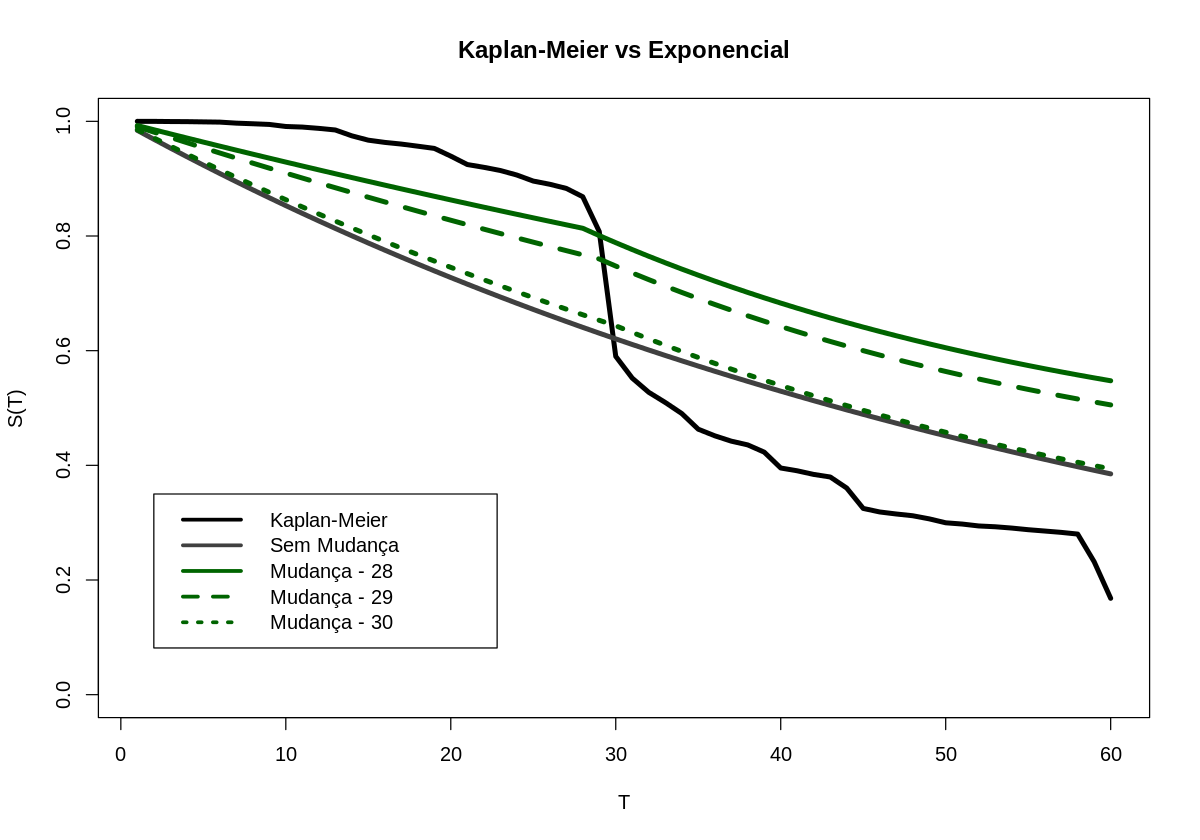

In [ ]:
# Função de sobrevivência do Modelo Exponencial com Ponto de Mudança:
sexpPM <- function(t, mu1, mu2, m){
  sweiPM(t, mu1, 1, mu2, 1, m)
}
# modelo exponencial sem ponto de mudanca:
mExp <- survreg(Surv(duration, censoring)~1, data=df, dist='exponential')

options(repr.plot.width = 10, repr.plot.height = 7)
plot(t_f0, s_f0, type='l', lwd=4, xlab='T', ylab='S(T)',
     main='Kaplan-Meier vs Exponencial', ylim=c(0,1))

lines(t_f0, 1-pexp(t_f0, 1/exp(mExp$coefficients)),
      lwd=4, col='#404040')

lines(sexpPM(t_f0, 4.91, 3.5, 28),
      col='dark green', lwd=4, lty=1)
lines(sexpPM(t_f0, 4.66, 3.52, 29),
      col='dark green', lwd=4, lty=2)
lines(sexpPM(t_f0, 4.22, 3.71, 30),
      col='dark green', lwd=4, lty=3)

legend(2, 0.35, c('Kaplan-Meier','Sem Mudança','Mudança - 28',
                  'Mudança - 29','Mudança - 30'),
       col=c('black','#404040',rep('dark green',3)),
       lwd=3, lty=c(1,1,1,2,3))

Dessa vez, vemos que os melhores pontos de mudança são 28 ou 29, mas na verdade, a distribuição exponencial não se ajusta bem aos dados. Ficaremos com a distribuição Weibull com ponto de mudança.

## Regressão

A partir da seção anterior, vemos que o modelo weibull com ponto de mudança se ajusta bem aos dados; assim, vamos incluir covariáveis que modificam seus parâmetros.

Como sabemos do trabalho anterior, as covariáveis aceleram ou atrasam o tempo até o evento (sucesso do projeto), então, segundo a definição de modelos de teste de falha acelerados, vamos incluir covariáveis da seguinte forma:

$$Y = log(T) = X'\beta + \epsilon, \text{ em que } \epsilon \sim VE_{PM}(0,\sigma_1, 0, \sigma_2, p) \ \text{ ou} \\
T = exp(X'\beta)exp(\epsilon) = exp(X'\beta)\epsilon^*, \text{ em que } \epsilon^* \sim W_{PM}(\frac{1}{\sigma_1}, 1, \frac{1}{\sigma_2}, 1, exp(p))$$

### Definição de algumas funções

In [ ]:
# Log Verossimilhanca com Covariaveis:
log.veros.reg <- function(params, m, t, c, X){
  # constantes:
  n = dim(X)[2]
  p = log(m)
  sig1 = params[length(params)-1]
  sig2 = params[length(params)]

  betas = params[1:(length(params)-2)]
  beta1 = betas[1:(length(betas)/2)]
  beta2 = betas[(length(betas)/2+1):(length(betas))]
  #cat('Betas:', beta1, '--', beta2, '\n')

  y1 = log(t[t <= m]); y2 = 0
  c1 = c[t <= m]; c2 = 0
  x1 = X[(t <= m), ]; x2 = matrix(0, nrow=1, ncol=n)
  if (m < max(t)) {
    y2 = log(t[t > m]); c2 = c[t > m]; x2 = X[(t > m), ]
  }

  # valores mu1 e mu2:
  mu1 = mean(as.double(   beta1 %*% t(x1)  ))
  mu2 = mean(as.double(   beta2 %*% t(x2)  ))
  #cat('Mu:', mu1, '--', mu2, '\n')

  # log(f1^c1)
  aux= sum( c1*log(dextvalPM(y1,p, mu1,sig1, mu2,sig2)) )
  # log(S1^(1-c1))
  aux= aux+ sum((1-c1)*log(1-pextvalPM(y1,p,mu1,sig1,mu2,sig2)))
  # log(f2^c2)
  aux= aux+ sum( c2*log(dextvalPM(y2,p, mu1,sig1, mu2,sig2)) )
  # log(S2^(1-c2))
  aux= aux+ sum((1-c2)*log(1-pextvalPM(y2,p,mu1,sig1,mu2,sig2)))

  # garantia para que o `optim` funcione:
  if (is.na(aux)){ aux <- -1e10 }
  return(aux)
}

In [ ]:
make_X <- function(n, ...){
  aux <- c(...)
  col_1 <- rep(1, n)

  if (length(aux)==1 && aux[1]==1){ return(matrix(col_1, nrow=n)) }
  else{
    return( matrix(c(col_1,aux), nrow=n) )
  }
}

# Testes:
#make_X(length(df$duration), df$shares, df$logS, df$logF)[1:5,]
#make_X(2, 1)

In [ ]:
make_regression <- function(t, c, rangeM, ...){
  n <- length(t)
  X <- make_X(n, ...)
  #print(dim(X))
  nX <- dim(X)[2]

  params <- c(rep(5, 2*nX), 0.3, 0.5)
  #params <- c(rep(2, 2*nX), 0.3, 0.5)
  #print(params)

  sigs = vSigs <- matrix(0, nrow=length(rangeM), ncol=2)
  coefs <- matrix(0, nrow=length(rangeM), ncol=2*nX)
  vCoefs <- matrix(0, nrow=length(rangeM), ncol=2*nX)
  veros <- NULL

  options(warn=-1)
  for (i in 1:length(rangeM)){
    out = optim(par=params, fn = log.veros.reg,
                #method = 'L-BFGS-B',
                #lower = c(rep(-5,2*nX), 0.01,0.01),
                #upper = c(rep(5,2*nX), 5,5),
                control=list(fnscale=-1), hessian=T,
                t=t, c=c, m=rangeM[i], X=X)
    #print(out$par)

    sigs[i,1] <- out$par[length(out$par)-1]
    sigs[i,2] <- out$par[length(out$par)]
    coefs[i,] <- out$par[1:(length(out$par)-2)]
    #print(coefs)
    #print(out$hessian)

    vars <- diag(solve(-out$hessian))
    vSigs[i,1] <- vars[length(vars)-1]
    vSigs[i,2] <- vars[length(vars)]
    vCoefs[i,] <- vars[1:(length(out$par)-2)]
    
    veros <- c(veros, log.veros.reg(out$par, rangeM[i], t, c, X))
    #print(log.veros.reg(out$par, rangeM[i], t, c, X))
  }
  options(warn=-0)

  # Resultados:
  res <- data.frame(pMudanca = rangeM, Sigma = sigs, Var.Sigma = vSigs,
                    Beta = coefs, Var.Beta = vCoefs, Log.Veros = veros)

  i <- order(veros, decreasing=TRUE)
  r <- res[i,]
  #print(r)
  aux <- r[1,-c(1,2,3,4,5,dim(r)[2])]
  coefs = aux[1:(length(aux)/2)]
  vcoef = aux[(length(aux)/2+1):(length(aux))]

  return(list(m = r[1,1], Sigmas = r[1,c(2,3)], varSigs = r[1,c(4,5)],
              Coeficientes = coefs, varCoefs = abs(vcoef),
              X=X, logveros = r[1,dim(res)[2]]))
}

# Teste:
#a <- make_regression(df$duration, df$censoring, 30:32, 1)
#cat('P. de Mudança:',a$m, '\nLog Verossimilhança:',a$logveros)

### Regressão com a $Weibull_{PM}$

Vamos começar a ajustar e testar os modelos com diferentes covariáveis e pontos de mudança.

In [ ]:
# Modelo Nulo vs Modelos com uma Cov.:
m0 <- make_regression(df$duration, df$censoring, 29, 1)
m1 <- make_regression(df$duration, df$censoring, 29, df$facebook)
m2 <- make_regression(df$duration, df$censoring, 29, df$logF)
m3 <- make_regression(df$duration, df$censoring, 29, df$logS)

trv <- 2*c(m0$logveros - m1$logveros,
           m0$logveros - m2$logveros,
           m0$logveros - m3$logveros)
pchi <- c(pchisq(trv, 1))

data.frame(Covariavel = c('Nenhuma', 'Facebook', 'logFriends', 'logShares'),
           logVeros=round(c(m0$logveros,m1$logveros,m2$logveros,m3$logveros),3),
           TVR = c('--', round(trv, 3)),
           pValor = c('--', round(pchi, 3)))

Covariavel,logVeros,TVR,pValor
<chr>,<dbl>,<chr>,<chr>
Nenhuma,-8606.232,--,--
Facebook,-8696.183,179.902,1
logFriends,-8606.836,1.209,0.728
logShares,-8897.337,582.21,1


In [ ]:
# Modelo Nulo vs Modelos com uma Cov.:
m0 <- make_regression(df$duration, df$censoring, 30, 1)
m1 <- make_regression(df$duration, df$censoring, 30, df$facebook)
m2 <- make_regression(df$duration, df$censoring, 30, df$logF)
m3 <- make_regression(df$duration, df$censoring, 30, df$logS)

trv <- 2*c(m0$logveros - m1$logveros,
           m0$logveros - m2$logveros,
           m0$logveros - m3$logveros)
pchi <- c(pchisq(trv, 1))

data.frame(Covariavel = c('Nenhuma', 'Facebook', 'logFriends', 'logShares'),
           logVeros=round(c(m0$logveros,m1$logveros,m2$logveros,m3$logveros),3),
           TVR = c('--', round(trv, 3)),
           pValor = c('--', round(pchi, 3)))

Covariavel,logVeros,TVR,pValor
<chr>,<dbl>,<chr>,<chr>
Nenhuma,-7387.652,--,--
Facebook,-7396.843,18.383,1
logFriends,-7680.729,586.154,1
logShares,-7388.004,0.704,0.599


In [ ]:
# Modelo Nulo vs Modelos com uma Cov.:
m0 <- make_regression(df$duration, df$censoring, 31, 1)
m1 <- make_regression(df$duration, df$censoring, 31, df$facebook)
m2 <- make_regression(df$duration, df$censoring, 31, df$logF)
m3 <- make_regression(df$duration, df$censoring, 31, df$logS)

trv <- 2*c(m0$logveros - m1$logveros,
           m0$logveros - m2$logveros,
           m0$logveros - m3$logveros)
pchi <- c(pchisq(trv, 1))

data.frame(Covariavel = c('Nenhuma', 'Facebook', 'logFriends', 'logShares'),
           logVeros=round(c(m0$logveros,m1$logveros,m2$logveros,m3$logveros),3),
           TVR = c('--', round(trv, 3)),
           pValor = c('--', round(pchi, 3)))

Covariavel,logVeros,TVR,pValor
<chr>,<dbl>,<chr>,<chr>
Nenhuma,-7329.037,--,--
Facebook,-7334.357,10.641,0.999
logFriends,-7329.039,0.004,0.051
logShares,-7329.597,1.121,0.71


In [ ]:
# Modelo Nulo vs Modelos com uma Cov.:
m0 <- make_regression(df$duration, df$censoring, 32, 1)
m1 <- make_regression(df$duration, df$censoring, 32, df$facebook)
m2 <- make_regression(df$duration, df$censoring, 32, df$logF)
m3 <- make_regression(df$duration, df$censoring, 32, df$logS)

trv <- 2*c(m0$logveros - m1$logveros,
           m0$logveros - m2$logveros,
           m0$logveros - m3$logveros)
pchi <- c(pchisq(trv, 1))

data.frame(Covariavel = c('Nenhuma', 'Facebook', 'logFriends', 'logShares'),
           logVeros=round(c(m0$logveros,m1$logveros,m2$logveros,m3$logveros),3),
           TVR = c('--', round(trv, 3)),
           pValor = c('--', round(pchi, 3)))

Covariavel,logVeros,TVR,pValor
<chr>,<dbl>,<chr>,<chr>
Nenhuma,-7419.484,--,--
Facebook,-8799.700,2760.431,1
logFriends,-10158.883,5478.797,1
logShares,-8467.786,2096.603,1


In [ ]:
# Modelo Nulo vs Modelos com uma Cov.:
m0 <- make_regression(df$duration, df$censoring, 33, 1)
m1 <- make_regression(df$duration, df$censoring, 33, df$facebook)
m2 <- make_regression(df$duration, df$censoring, 33, df$logF)
m3 <- make_regression(df$duration, df$censoring, 33, df$logS)

trv <- 2*c(m0$logveros - m1$logveros,
           m0$logveros - m2$logveros,
           m0$logveros - m3$logveros)
pchi <- c(pchisq(trv, 1))

data.frame(Covariavel = c('Nenhuma', 'Facebook', 'logFriends', 'logShares'),
           logVeros=round(c(m0$logveros,m1$logveros,m2$logveros,m3$logveros),3),
           TVR = c('--', round(trv, 3)),
           pValor = c('--', round(pchi, 3)))

Covariavel,logVeros,TVR,pValor
<chr>,<dbl>,<chr>,<chr>
Nenhuma,-7588.323,--,--
Facebook,-8429.834,1683.021,1
logFriends,-8281.950,1387.252,1
logShares,-7612.570,48.493,1


Veja que o único modelo que "aceita" a inclusão de covariáveis é aquele com ponto de mudança em 31, e mesmo assim, apenas `logFriends` é significativa.

In [ ]:
# Modelo final:
m2 <- make_regression(df$duration, df$censoring, 31, df$logF)

# Tabela dos Coeficientes:
z = as.double(m2$Coeficientes/sqrt(m2$varCoefs))
aux <- data.frame(Estimativa = as.double(c(m2$Sigmas, m2$Coeficientes)),
                  Erro_Padrao= sqrt(as.double(c(m2$varSigs, m2$varCoefs))),
                  Z = c('--','--', round(z,4)),
                  pValor = c('--','--', 1-round(pnorm(z),4))
                  )
row.names(aux) <- c('Sigma_1', 'Sigma_2', 'Beta_01',
                    'Beta_11', 'Beta_02', 'Beta_12')
print(aux, digits=3)

        Estimativa Erro_Padrao       Z pValor
Sigma_1      0.153     0.00197      --     --
Sigma_2      0.601     0.00462      --     --
Beta_01      0.747     0.49434  1.5103 0.0655
Beta_11      0.460     0.08162  5.6362      0
Beta_02     15.817    81.64190  0.1937 0.4232
Beta_12     -1.980    13.54430 -0.1462 0.5581


Considerando que $X_F$ diz respeito a covariável `logFriends`, então temos a seguinte fórmula para o modelo final:

$$ S(t|X_F) = \begin{cases}
exp(-(\frac{t}{exp(0.747 + 0.460*X_F)})^{\frac{1}{0.153}}), \text{ se t} \le 31 \\ \\
exp(-(\frac{31}{exp(0.747 + 0.460*X_F)})^{\frac{1}{0.153}}) - exp(-(\frac{31}{exp(15.817 - 1.98*X_F)})^{\frac{1}{0.6}}) + exp(-(\frac{t}{exp(15.817 - 1.98*X_F)})^{\frac{1}{0.6}}), \text{ se t} \gt 31
\end{cases}
$$

In [ ]:
# Função de sobrevivência do Modelo Weibull com Ponto de Mudança
# para dados valores de X_F:
sweiPM.reg <- function(t, xf){
  mu1 <- as.double(m2$Coeficientes[1] + m2$Coeficientes[2]*xf)
  mu2 <- as.double(m2$Coeficientes[3] + m2$Coeficientes[4]*xf)
  #cat(t, '--', mu1, '--', mu2, '\n')
  
  aux <- sweiPM(t, mu1, m2$Sigmas[1], mu2, m2$Sigmas[2], m2$m)
  return(aux)
}
sweiPM.reg <- Vectorize(sweiPM.reg, 't')

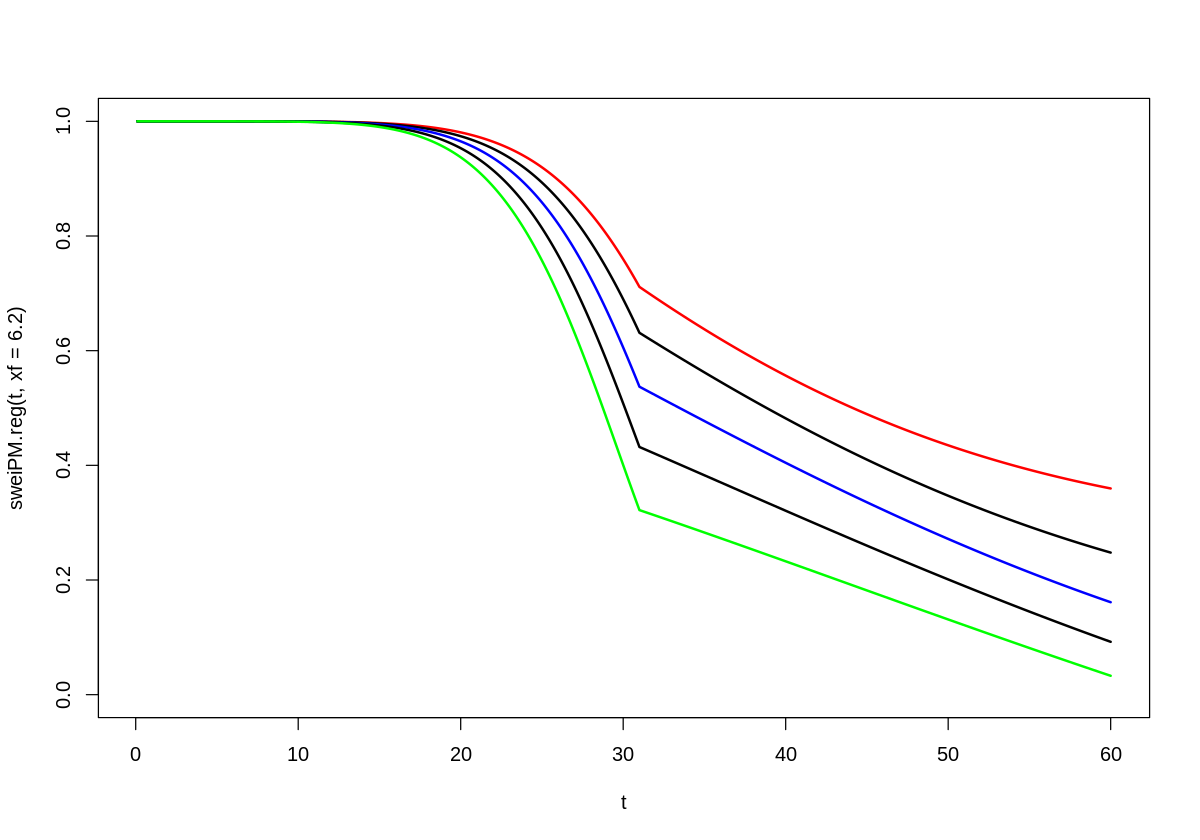

In [ ]:
# graficos com algumas comparacoes interessantes:
options(repr.plot.width = 10, repr.plot.height = 7)

t <- seq(0.1, 60, 0.1)

plot(t, sweiPM.reg(t, xf=6.2), type='l', lwd=2, ylim=c(0,1), col='red')
lines(t, sweiPM.reg(t, xf=6.1), lwd=2)
lines(t, sweiPM.reg(t, xf=6), lwd=2, col='Blue')
lines(t, sweiPM.reg(t, xf=5.9), lwd=2)
lines(t, sweiPM.reg(t, xf=5.8), lwd=2, col='green')

* Gráfico KM  e melhor modelo plot

## Análise dos resíduos

In [ ]:
# Funções para o calculo dos residuos:
HweiPM.reg <- function(t, xf){ - log(sweiPM.reg(t, xf)+0.1)}

cox_snell <- function(t, xf){
  res <- NULL
  for (i in 1:length(t)){
    aux <- HweiPM.reg(t[i], xf[i])
    if (is.na(aux)){cat(t[i], xf[i], '\n')}
    res <- c(res, aux)
  }
  return(res)
}

res.martingal <- function(t, c, xf){ c - cox_snell(t, xf) }

res.deviance <- function(t, c, xf){
  m <- res.martingal(t, c, xf)
  s <- m/abs(m)
  aux <- m + c*log(c - m)
  d <- s*sqrt(-2*aux)
  return(d)
}

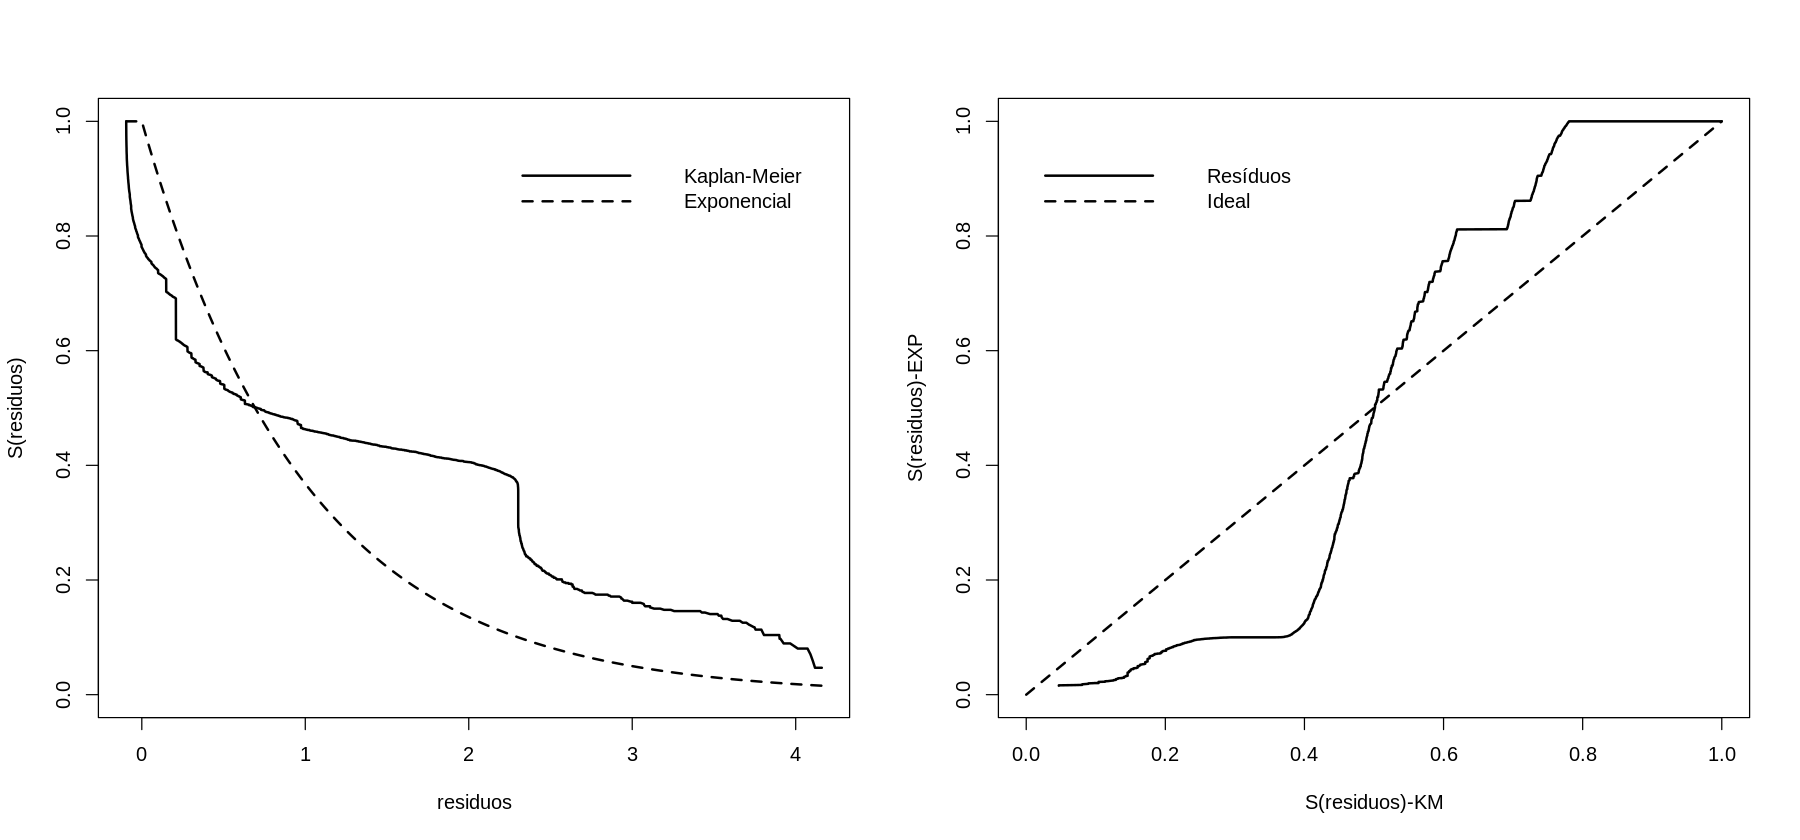

In [ ]:
# grafico de hat{e} vs S_0(hat{e}):
options(warn=-1)
res <- cox_snell(df$duration, df$logF)
res.cs <- survfit(Surv(res, df$censoring)~1)


options(repr.plot.width = 15, repr.plot.height = 7)
par(mfrow=c(1,2))

plot(res.cs$time, res.cs$surv, ylim=c(0,1), lwd=2, type='l',
     xlab='residuos', ylab='S(residuos)')
lines(res.cs$time, 1-pexp(res.cs$time, 1), lwd=2, lty=2)
legend(2, 0.95, c('Kaplan-Meier', 'Exponencial'), lwd=2,
      lty=c(1,2), bty='n')

plot(res.cs$surv, 1-pexp(res.cs$time,1), ylim=c(0,1), lwd=2, type='l',
     xlab='S(residuos)-KM', ylab='S(residuos)-EXP', xlim=c(0,1))
lines(0:1, 0:1, lwd=2, lty=2)
legend(-0.05, 0.95, c('Resíduos', 'Ideal'), lwd=2,
       lty=c(1,2), bty='n')
options(warn=0)

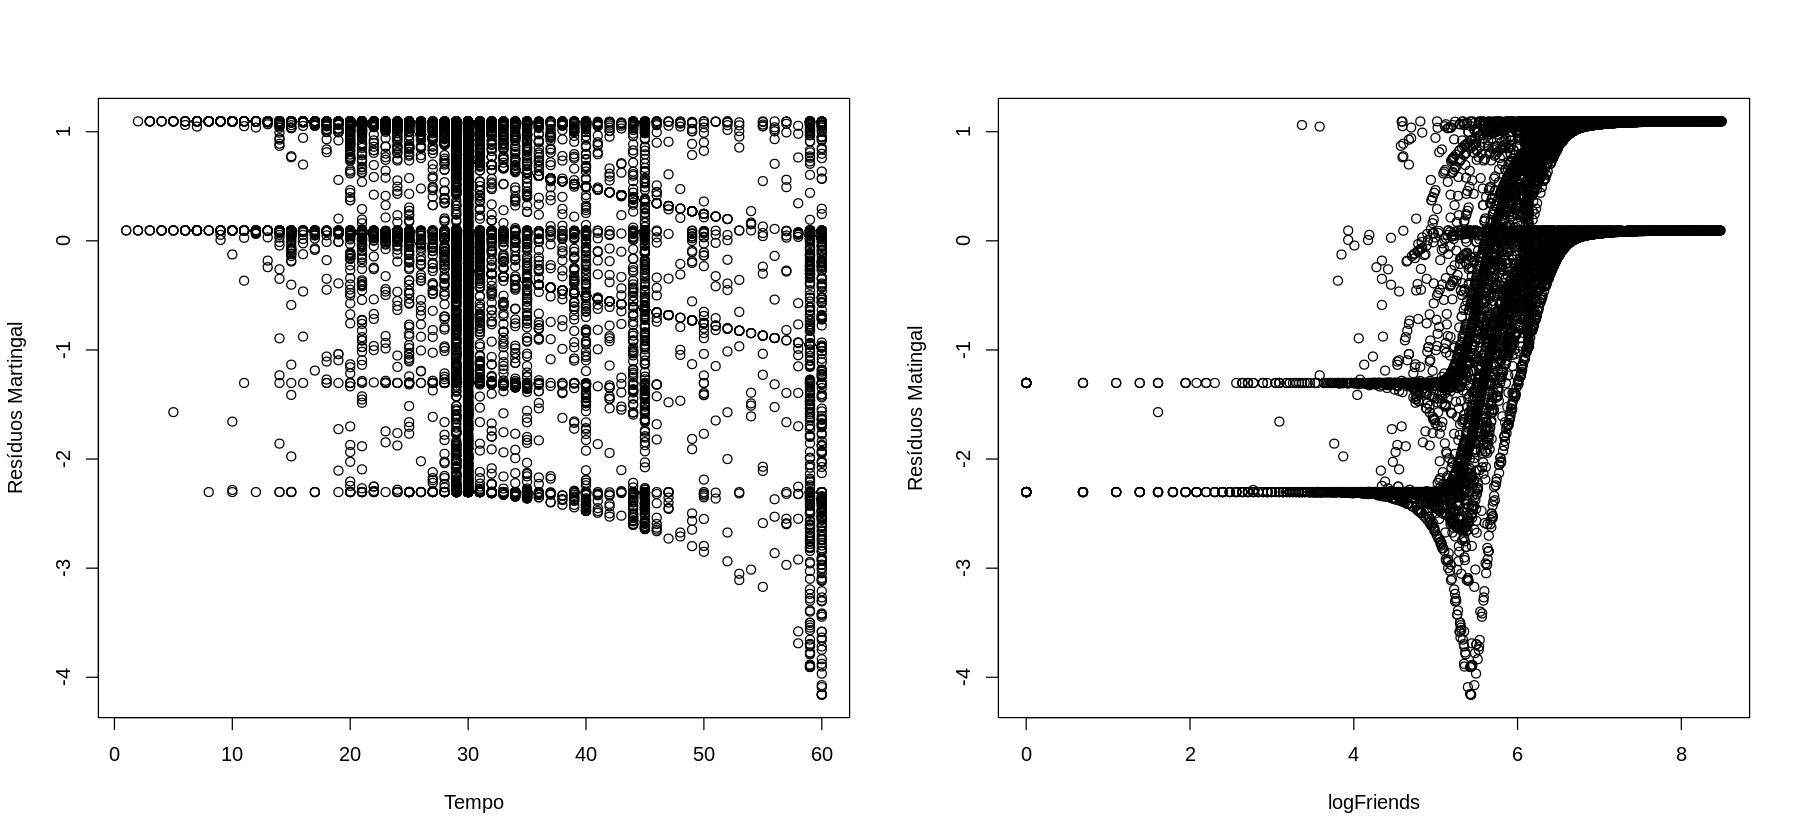

In [ ]:
# graficos de T e logF vs res.martingal:
options(warn=-1)
m = res.martingal(df$duration, df$censoring, df$logF)
options(warn=0)

options(repr.plot.width = 15, repr.plot.height = 7)
par(mfrow=c(1,2))

plot(df$duration, m, ylab='Resíduos Martingal', xlab='Tempo')
plot(df$logF, m, ylab='Resíduos Matingal', xlab='logFriends')

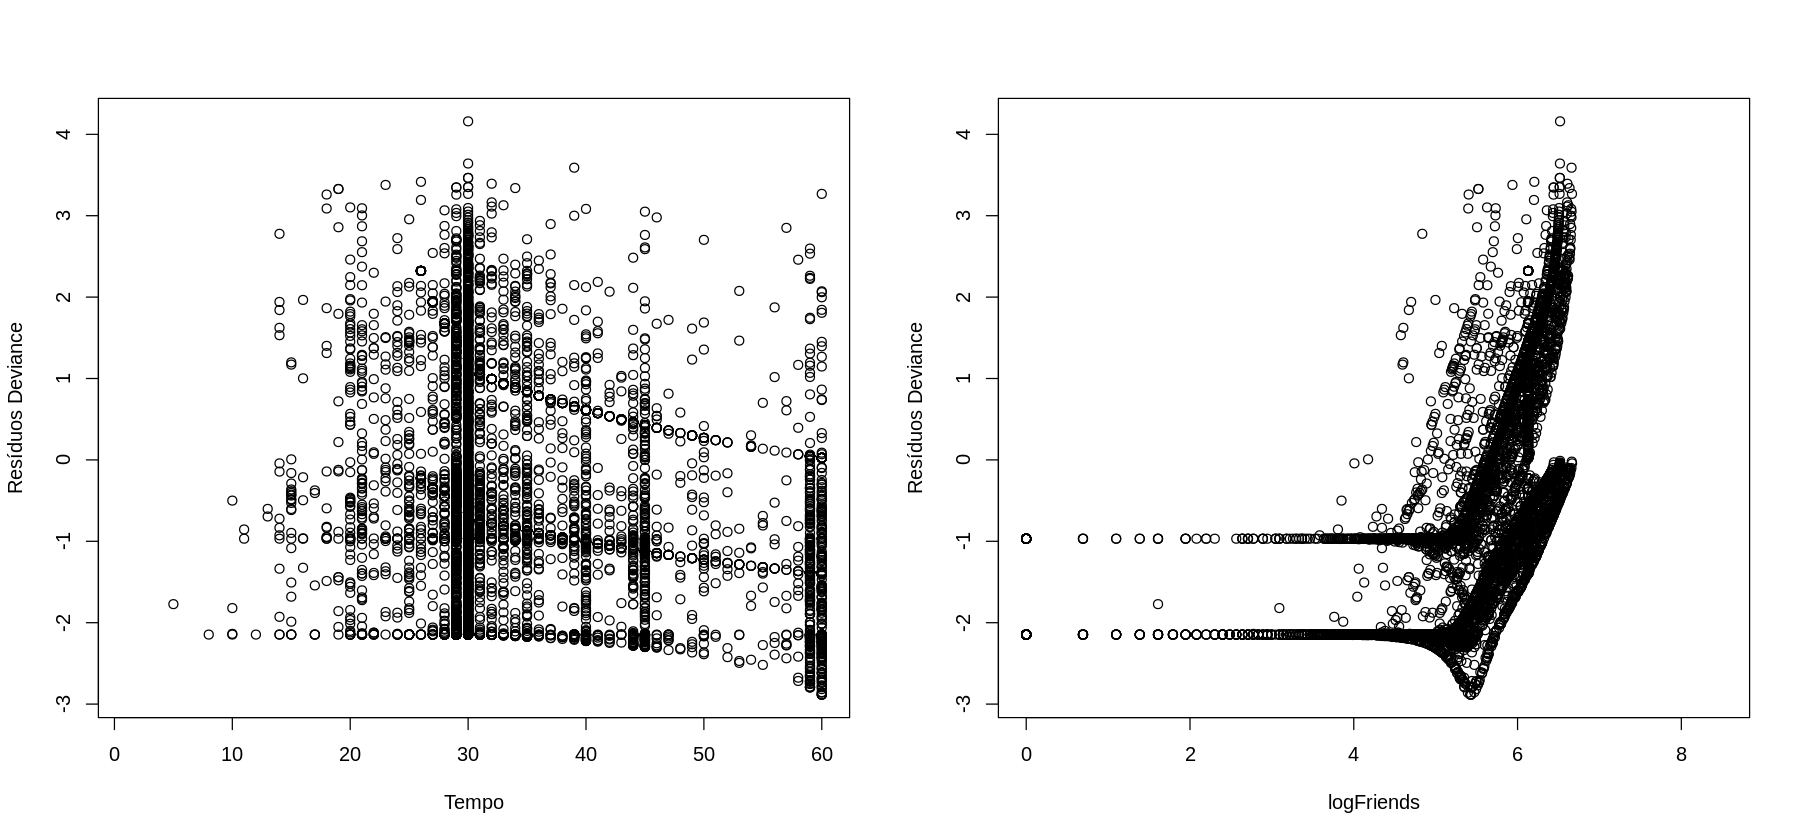

In [ ]:
# graficos de T e logF vs res.deviance:
options(warn=-1)
d = res.deviance(df$duration, df$censoring, df$logF)
options(warn=0)

options(repr.plot.width = 15, repr.plot.height = 7)
par(mfrow=c(1,2))

plot(df$duration, d, xlab='Tempo', ylab='Resíduos Deviance')
plot(df$logF, d, xlab='logFriends', ylab='Resíduos Deviance')

# Modelos de Cox


## Regressão

Inicialmente, criaremos alguns modelos de interesse e aplicaremos testes de razão de verossimilhança para definir quais covariáveis são significativas.

In [ ]:
args(coxph)

function (formula, data, weights, subset, na.action, init, control, 
    ties = c("efron", "breslow", "exact"), singular.ok = TRUE, 
    robust, model = FALSE, x = FALSE, y = TRUE, tt, method = ties, 
    id, cluster, istate, statedata, nocenter = c(-1, 0, 1), ...) 
NULL

In [ ]:
glimpse(df)

Rows: 16,850
Columns: 7
$ duration  <int> 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, …
$ censoring <int> 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, …
$ shares    <dbl> 7, 53, 2, 1, 3, 1, 23, 16, 23, 5, 57, 1, 73, 259, 6, 55, 66,…
$ facebook  <fct> 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, …
$ friends   <dbl> 1220, 1029, 229, 459, 1431, 173, 477, 915, 459, 665, 459, 30…
$ logF      <dbl> 7.106606, 6.936343, 5.433722, 6.129050, 7.266129, 5.153292, …
$ logS      <dbl> 1.9459101, 3.9702919, 0.6931472, 0.0000000, 1.0986123, 0.000…


Se $x_1$ representa Facebook, $x_2$, a quantidade de compartilhamentes, $x_3$ a quantidade de amigos, estamos interessados principalmente no impacto do facebook no sucesso dos projetos, bem como as possíveis interações de facebook com as outras covariáveis.












**Modelo 0**
$$h(t|x) = h_0(t)$$


**Modelo 1**
$$h(t|x) = h_0 exp(\beta_1x_1)$$

**Modelo 2**
$$h(t|x) = h_0 exp(\beta_2x_2)$$


**Modelo 3**
$$h(t|x) = h_0 exp(\beta_3x_3)$$

**Modelo 4**
$$h(t|x) = h_0 exp(\beta_1x_1 + \beta_2x_2)$$


**Modelo 5**
$$h(t|x) = h_0 exp(\beta_1x_1 + \beta_3x_3 )$$

**Modelo 6**
$$h(t|x) = h_0 exp( \beta_2x_2 +\beta_3x_3 )$$


**Modelo 7**
$$h(t|x) = h_0 exp( \beta_1x_1 +\beta_2x_2 +\beta_3x_3 )$$


**Modelo 8**
$$h(t|x) = h_0 exp(\beta_1x_1 + \beta_2x_2 + \beta_3x_3 + \beta_4x_1x_2)$$

**Modelo 9**
$$h(t|x) = h_0 exp( \beta_2x_2 + \beta_3x_3 + \beta_4x_1x_2 + \beta_5x_1x_3)$$


**Modelo 10**
$$h(t|x) = h_0 exp( \beta_2x_2 + \beta_3x_3 + \beta_4x_1x_2 + \beta_5x_2x_3)$$

**Modelo 11**
$$h(t|x) = h_0 exp(\beta_1x_1 + \beta_2x_2 + \beta_3x_3 + \beta_4x_1x_2 + \beta_5x_2x_3)$$

In [ ]:
m0<-coxph(Surv(duration,censoring)~1, data=df,x=T, method="breslow")
m1<-coxph(Surv(duration,censoring)~facebook, data=df,x=T, method="breslow")
m2<-coxph(Surv(duration,censoring)~shares, data=df,x=T, method="breslow")
m3<-coxph(Surv(duration,censoring)~friends, data=df,x=T, method="breslow")
m4<-coxph(Surv(duration,censoring)~facebook + friends, data=df,x=T, method="breslow")
m5<-coxph(Surv(duration,censoring)~facebook + shares, data=df,x=T, method="breslow")
m6<-coxph(Surv(duration,censoring)~friends + shares, data=df,x=T, method="breslow")


m7<-coxph(Surv(duration,censoring)~facebook + friends + shares, data=df,x=T, method="breslow")
m8<-coxph(Surv(duration,censoring)~ friends + shares + facebook*shares, data=df,x=T, method="breslow")
m9<-coxph(Surv(duration,censoring)~ friends + shares + facebook*shares + facebook*friends, data=df,x=T, method="breslow")
m10<-coxph(Surv(duration,censoring)~ friends + shares + facebook*shares + friends*shares, data=df,x=T, method="breslow")
m11<-coxph(Surv(duration,censoring)~facebook + friends + shares + facebook*shares + friends*shares, data=df,x=T, method="breslow")



Agora testaremos a relevância das covariáveis individualmente.

In [ ]:
anova(m0,m1)
anova(m0,m2)
anova(m0,m3)

Warning message in anova.coxph(m0, m1, xlab = "Facebook"):
“The following arguments to anova.coxph(..) are invalid and dropped: list(xlab = "Facebook")”


,loglik,Chisq,Df,P(>|Chi|)
,<dbl>,<dbl>,<dbl>,<dbl>
1,-76354.32,NA,NA,NA
2,-76351.38,5.877758,1,0.01533333


,loglik,Chisq,Df,P(>|Chi|)
,<dbl>,<dbl>,<dbl>,<dbl>
1,-76354.32,NA,NA,NA
2,-76339.06,30.52883,1,3.289413e-08


,loglik,Chisq,Df,P(>|Chi|)
,<dbl>,<dbl>,<dbl>,<dbl>
1,-76354.32,NA,NA,NA
2,-76300.44,107.7728,1,3.014287e-25


Comparando m1 com o modelo nulo, concluimos que a adição de facebook no modelo é válida. Ao repetir o procedimento para m2 e m3, também concluimos que, em relação ao modelo nulo, a adição de todas as covariáveis é significativa.

,loglik,Chisq,Df,P(>|Chi|)
,<dbl>,<dbl>,<dbl>,<dbl>
1,-76354.32,NA,NA,NA
2,-76339.06,30.52883,1,3.289413e-08


,loglik,Chisq,Df,P(>|Chi|)
,<dbl>,<dbl>,<dbl>,<dbl>
1,-76354.32,NA,NA,NA
2,-76300.44,107.7728,1,3.014287e-25


Agora, tomando o modelo 1 como referência, desejamos encontrar o impacto da adição de friends e shares.

In [ ]:
anova(m1,m4)
anova(m1,m5)

,loglik,Chisq,Df,P(>|Chi|)
,<dbl>,<dbl>,<int>,<dbl>
1,-76351.38,NA,NA,NA
2,-76300.29,102.1898,1,5.044851e-24


,loglik,Chisq,Df,P(>|Chi|)
,<dbl>,<dbl>,<int>,<dbl>
1,-76351.38,NA,NA,NA
2,-76335.69,31.39613,1,2.104002e-08


,loglik,Chisq,Df,P(>|Chi|)
,<dbl>,<dbl>,<int>,<dbl>
1,-76351.38,NA,NA,NA
2,-76335.69,31.39613,1,2.104002e-08


Concluimos que a adição individual de friends e shares ao modelo 1 é significativa, ou seja, seus coeficientes não são nulos. Em seguida precisamos verificar se na presença de duas covariáveis, uma terceira é significativa.

In [ ]:
anova(m4,m7)
anova(m5,m7)
anova(m6,m7)

,loglik,Chisq,Df,P(>|Chi|)
,<dbl>,<dbl>,<int>,<dbl>
1,-76300.29,NA,NA,NA
2,-76286.14,28.2927,1,1.042885e-07


,loglik,Chisq,Df,P(>|Chi|)
,<dbl>,<dbl>,<int>,<dbl>
1,-76335.69,NA,NA,NA
2,-76286.14,99.08639,1,2.417235e-23


,loglik,Chisq,Df,P(>|Chi|)
,<dbl>,<dbl>,<int>,<dbl>
1,-76286.41,NA,NA,NA
2,-76286.14,0.5270694,1,0.4678415


Notamos que a única covariável que não é significativa na presença de outras duas é facebook, logo prosseguiremos com um modelo apenas com friends e shares.

Em seguida, analisamos a possibilidade de adicionar a interação de covariáveis. Comparando o modelo m6 com m8, concluimos que a interação de facebook e shares é significativa.

In [ ]:
anova(m6,m8)

,loglik,Chisq,Df,P(>|Chi|)
,<dbl>,<dbl>,<int>,<dbl>
1,-76286.41,NA,NA,NA
2,-76262.32,48.17487,2,3.459081e-11


Comparando o m8 com m9, veremos se a adição de facebook*friends é possível

In [ ]:
anova(m8,m9)

,loglik,Chisq,Df,P(>|Chi|)
,<dbl>,<dbl>,<int>,<dbl>
1,-76262.32,NA,NA,NA
2,-76262.32,0,0,1


Como o p-valor é alto, concluimos que essa interação não é necessária ao modelo. Agora testaremos a adição de friends*shares

In [ ]:
anova(m8,m10)

,loglik,Chisq,Df,P(>|Chi|)
,<dbl>,<dbl>,<int>,<dbl>
1,-76262.32,NA,NA,NA
2,-76253.89,16.85618,1,4.032192e-05


Assim, encerramos nossa análise com o modelo 10. Precisamos agora estudar a adequabilidade do modelo.

## Adequabilidade do Modelo

Nota-se que as covariáveis que possuem shares não possuem geram um modelo com as taxas de risco proporcionais.

In [ ]:
(temp=cox.zph(m10, terms = F))

                  chisq df       p
friends           0.511  1    0.47
shares           65.499  1 5.8e-16
facebook1         0.116  1    0.73
shares:facebook1 37.809  1 7.8e-10
friends:shares   25.664  1 4.1e-07
GLOBAL           69.311  5 1.4e-13

In [ ]:
summary(m12)

ERROR: ignored

Interpretação pelo risco??????????

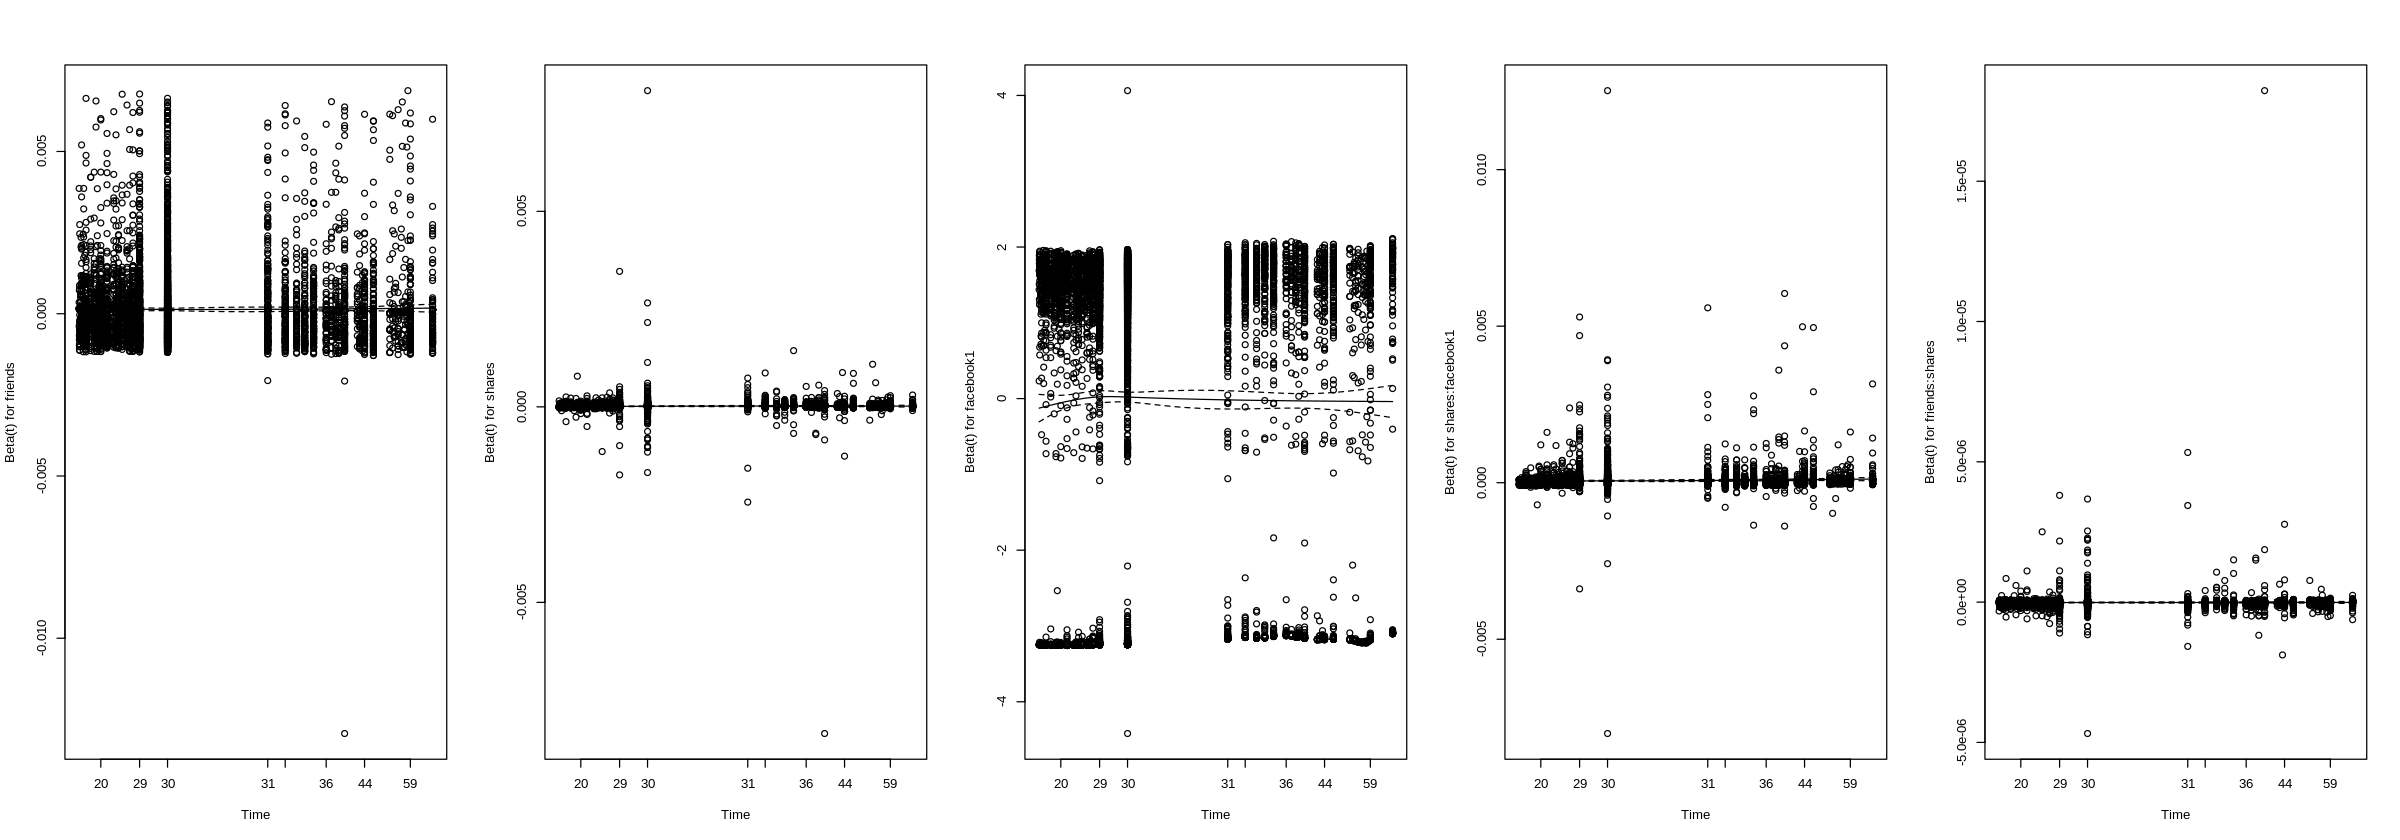

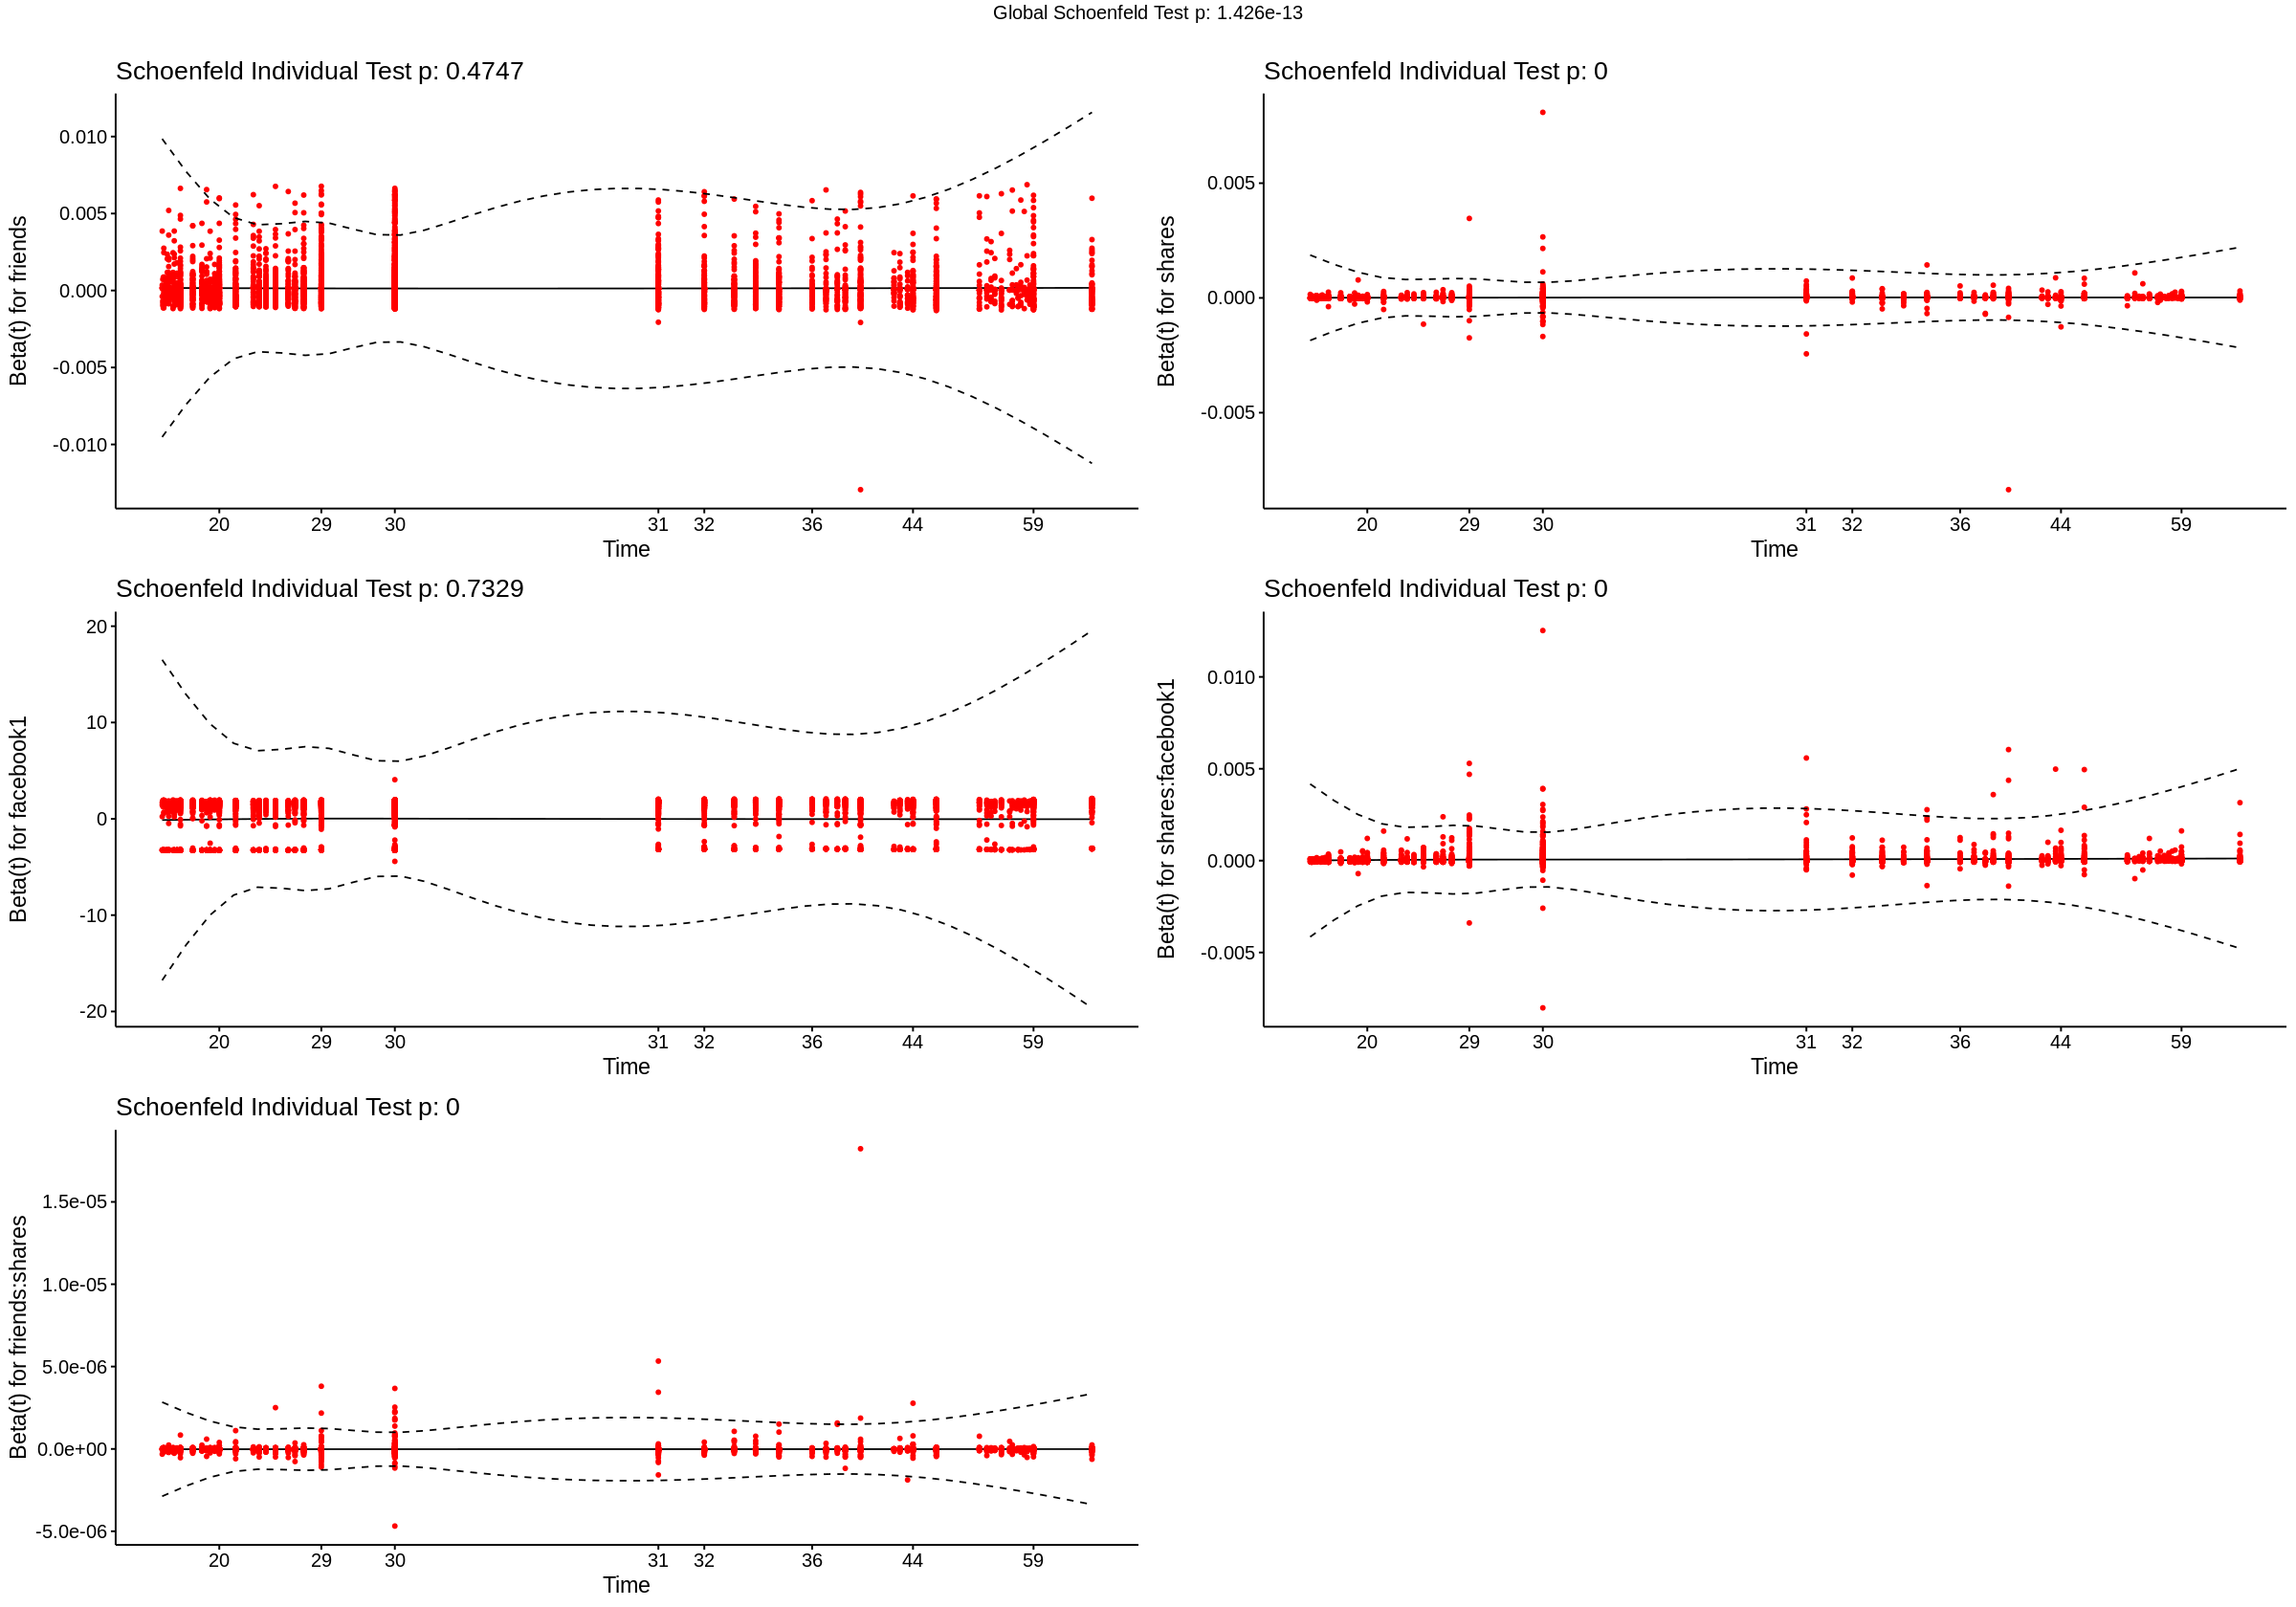

In [ ]:
options(repr.plot.width = 20, repr.plot.height = 7)
par(mfrow=c(1,5))
plot(temp)

options(repr.plot.width = 20, repr.plot.height = 14)
par(mfrow=c(2,3))
ggcoxzph(temp)

In [ ]:
*COLOCAR Kaplan Meier de FRIENDS

Os resíduos das covariáveis que tem presença de shares, parecem ter uma tendência em relação ao tempo, o que significa que eles não satisfazem a proporcionalidade de risco.

In [ ]:
df$inv_friends <- (1/df$friends)

In [ ]:
m12<-coxph(Surv(duration,censoring)~ log(friends),
           data=df,x=T, method="breslow")


In [ ]:
(temp=cox.zph(m12, terms = F))

             chisq df    p
log(friends)  1.55  1 0.21
GLOBAL        1.55  1 0.21

In [ ]:
summary(m12)

Call:
coxph(formula = Surv(duration, censoring) ~ log(friends), data = df, 
    x = T, method = "breslow")

  n= 16850, number of events= 8451 

                coef exp(coef) se(coef)     z Pr(>|z|)    
log(friends) 0.23016   1.25880  0.01196 19.24   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

             exp(coef) exp(-coef) lower .95 upper .95
log(friends)     1.259     0.7944      1.23     1.289

Concordance= 0.577  (se = 0.004 )
Likelihood ratio test= 402.3  on 1 df,   p=<2e-16
Wald test            = 370.1  on 1 df,   p=<2e-16
Score (logrank) test = 356.2  on 1 df,   p=<2e-16


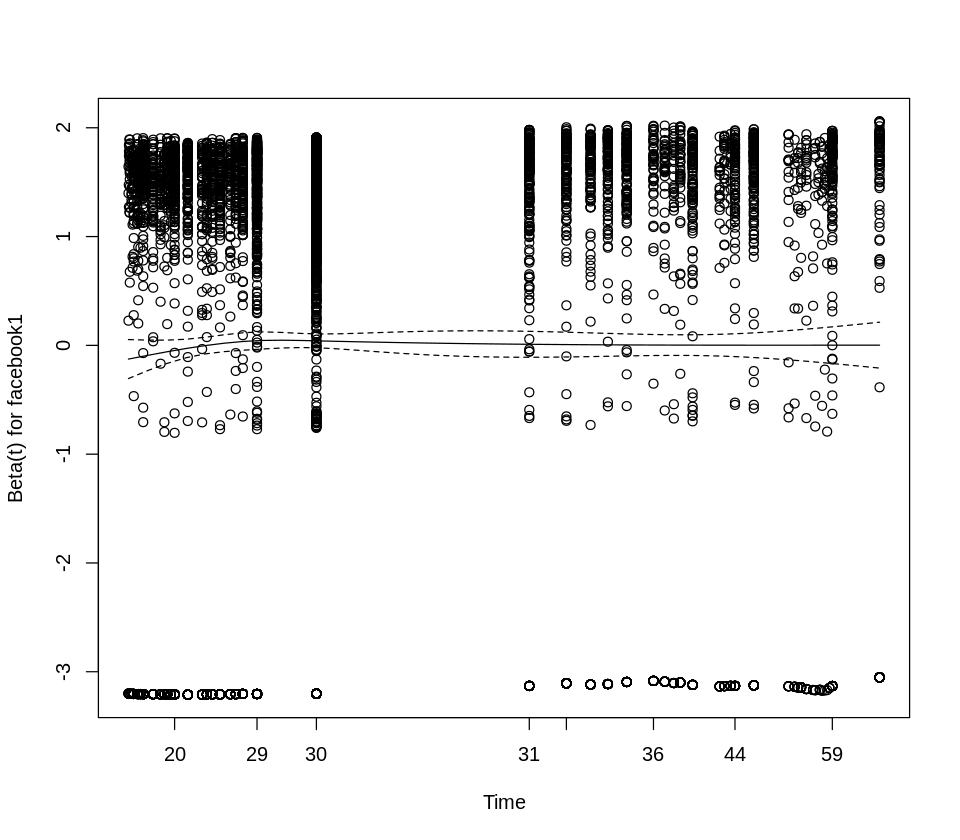

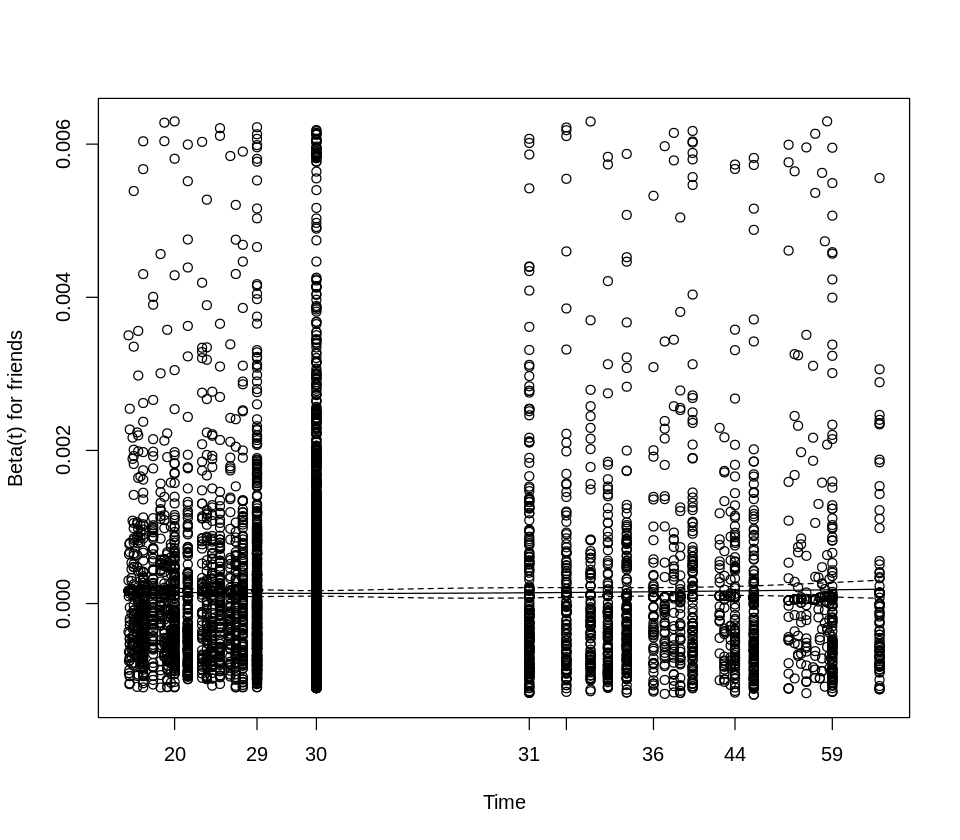

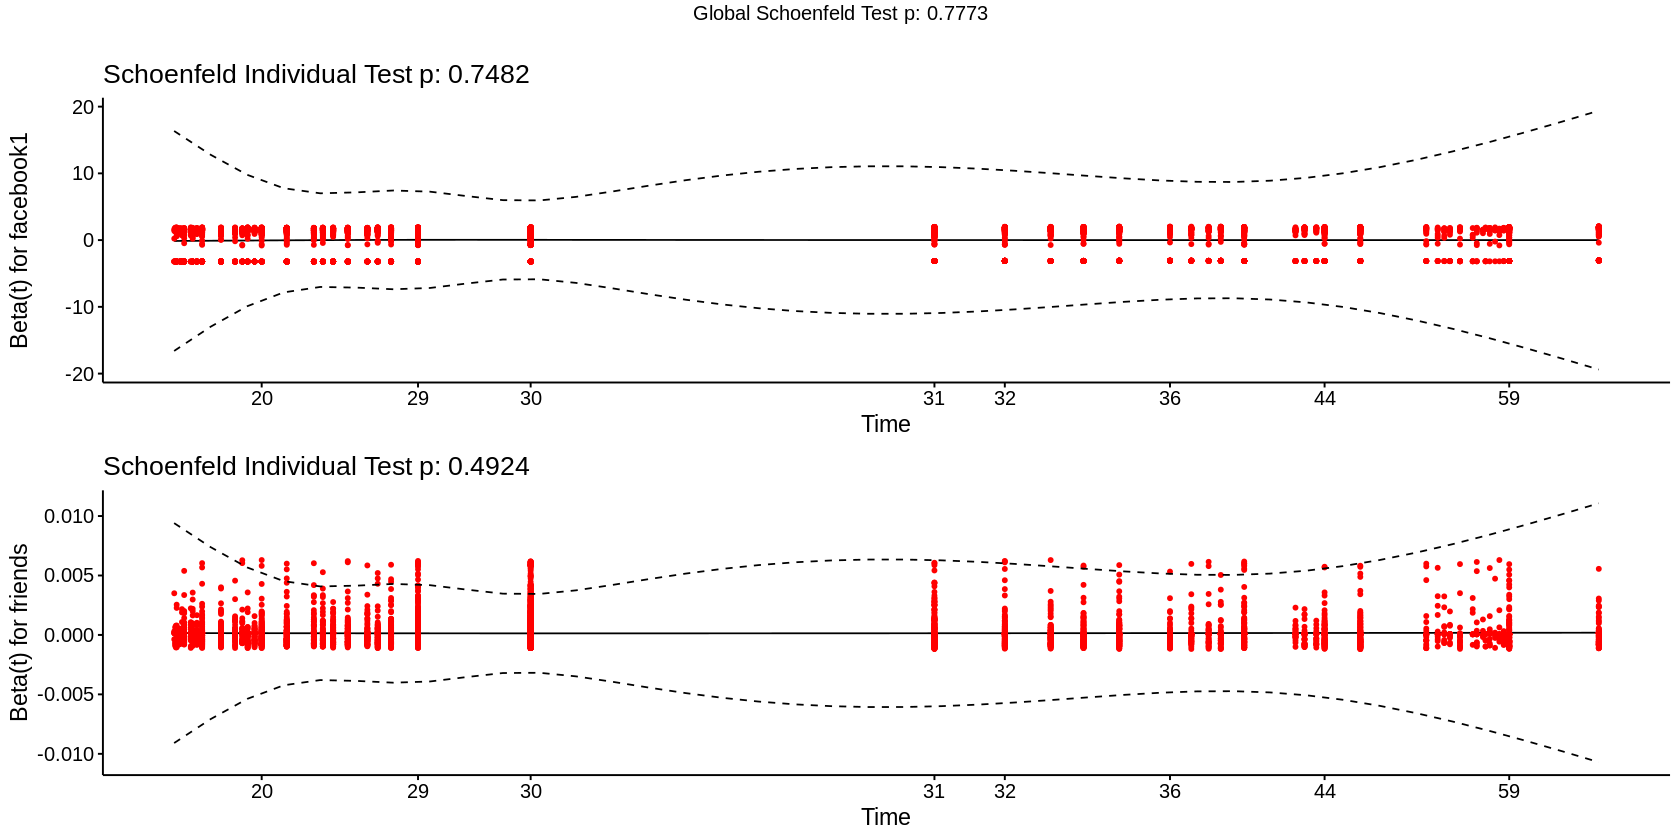

In [ ]:
options(repr.plot.width = 8, repr.plot.height = 7)
#par(mfrow=c(2,4))
plot(temp)

options(repr.plot.width = 14, repr.plot.height = 7)
par(mfrow=c(1,2))
ggcoxzph(temp)

## Estimação de $h_0$

In [ ]:
Ht<-basehaz(m12, centered=F)

Warning message in survfit.coxph(fit, se.fit = FALSE):
“the model contains interactions; the default curve based on columm means of the X matrix is almost certainly not useful. Consider adding a newdata argument.”


In [ ]:
tempos<-Ht$time
H0<-Ht$hazard
S0<- exp(-H0)
round(cbind(tempos,S0,H0), digits=5)

tempos,S0,H0
1,1.00000,0.00000
2,0.99995,0.00005
3,0.99968,0.00032
4,0.99952,0.00048
5,0.99914,0.00086
6,0.99877,0.00123
7,0.99716,0.00284
8,0.99619,0.00381
9,0.99512,0.00489
10,0.99190,0.00813


## Adequabilidade e pontos influentes


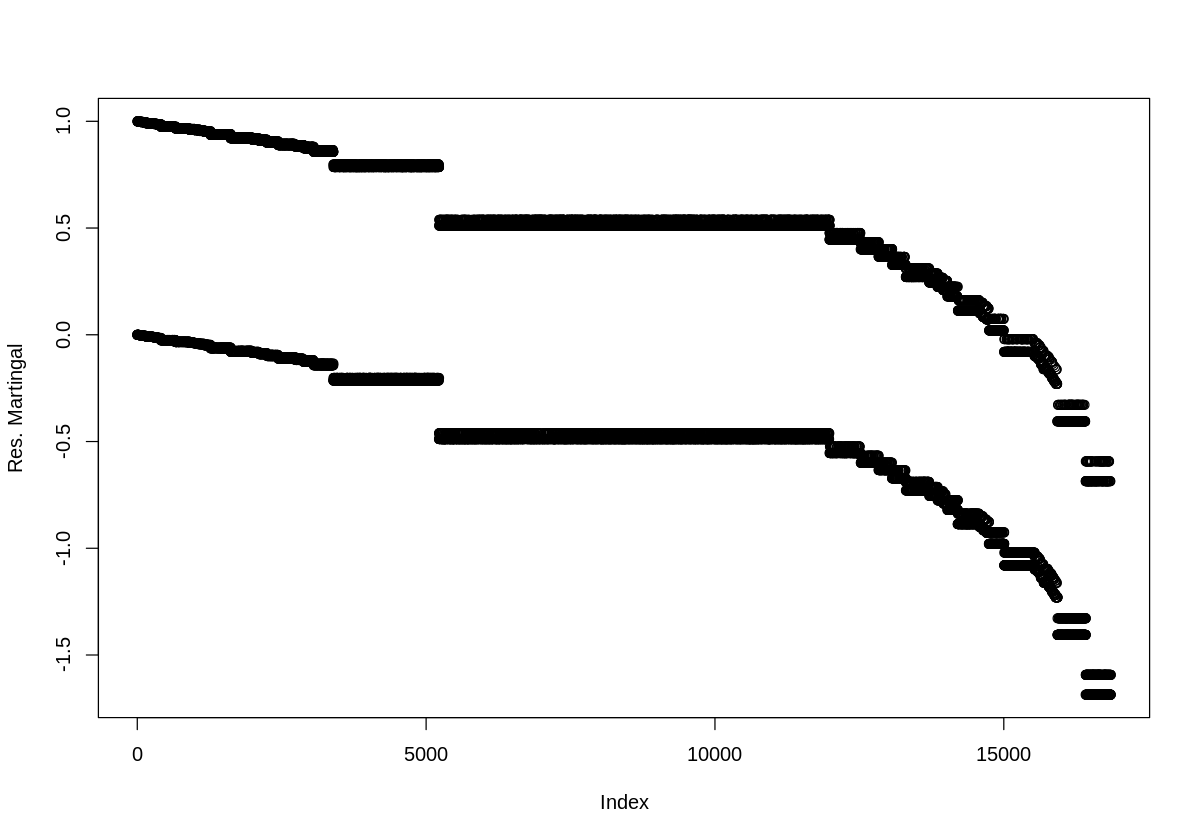

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 7)
res_M=residuals(m1,type = "martingal")
plot(res_M,ylab="Res. Martingal")

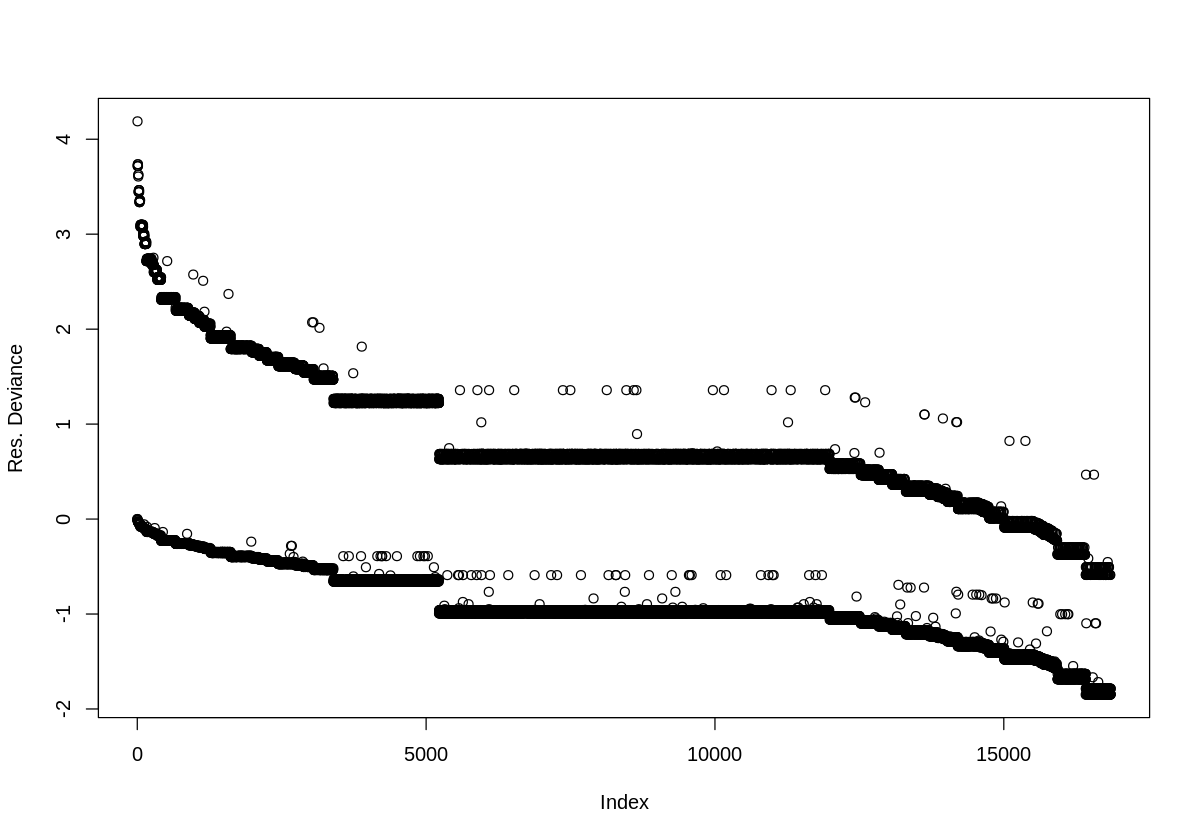

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 7)
res_D=residuals(m12,type = "deviance")
plot(res_D, ylab="Res. Deviance")

Warning message:
“`gather_()` was deprecated in tidyr 1.2.0.
Please use `gather()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was generated.”
`geom_smooth()` using formula 'y ~ x'



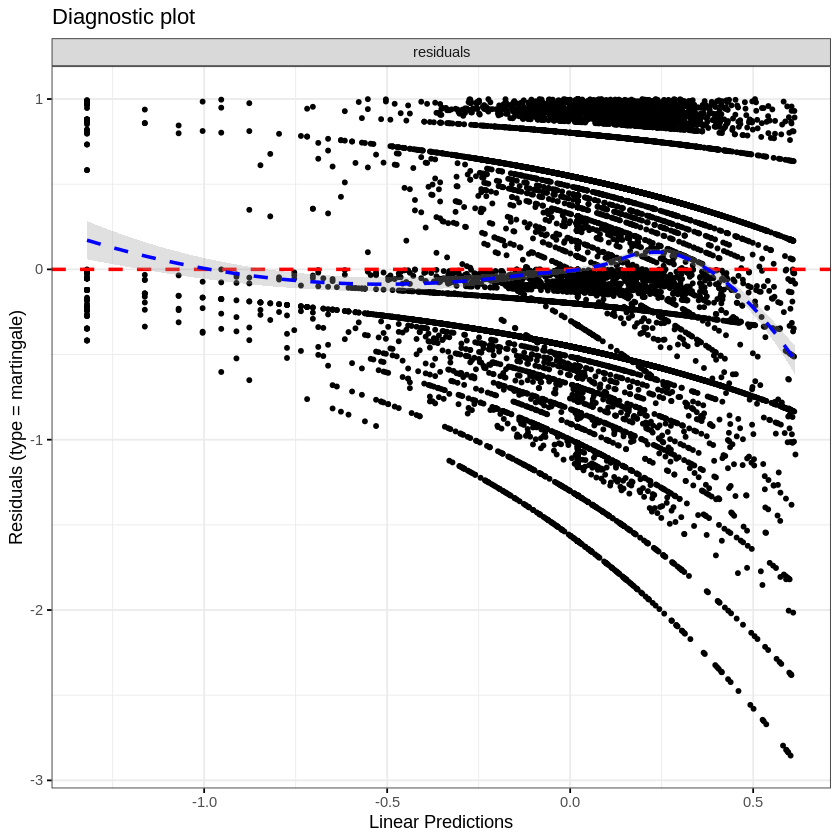

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 7)
ggcoxdiagnostics(m12, type = "martingale", title = "Diagnostic plot")

`geom_smooth()` using formula 'y ~ x'



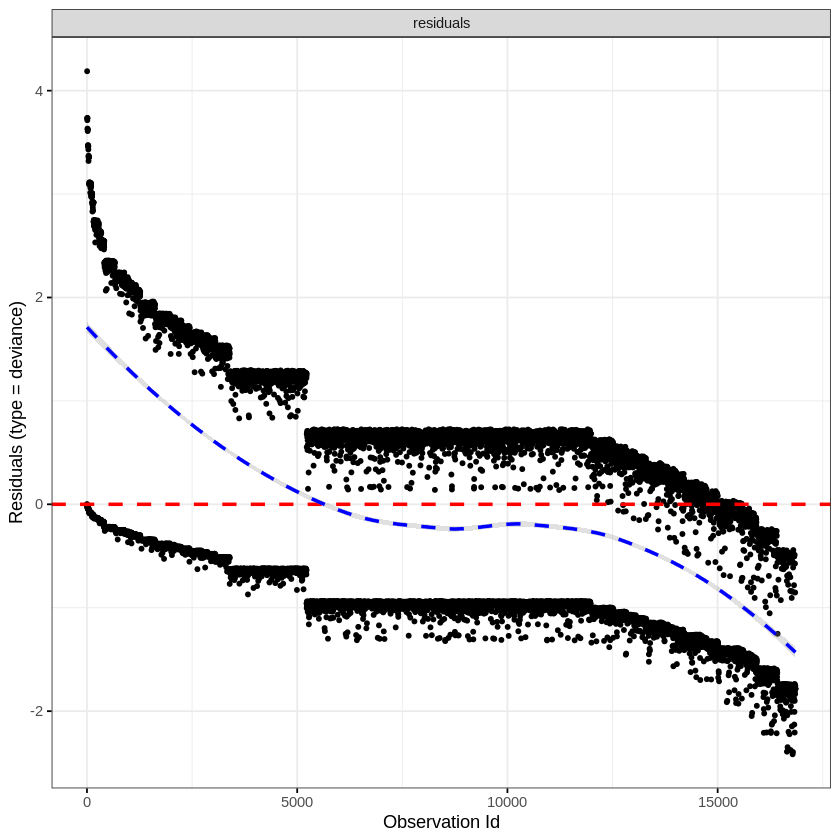

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 7)
ggcoxdiagnostics(m12, type = "deviance",
                 linear.predictions = F, ggtheme = theme_bw())

`geom_smooth()` using formula 'y ~ x'



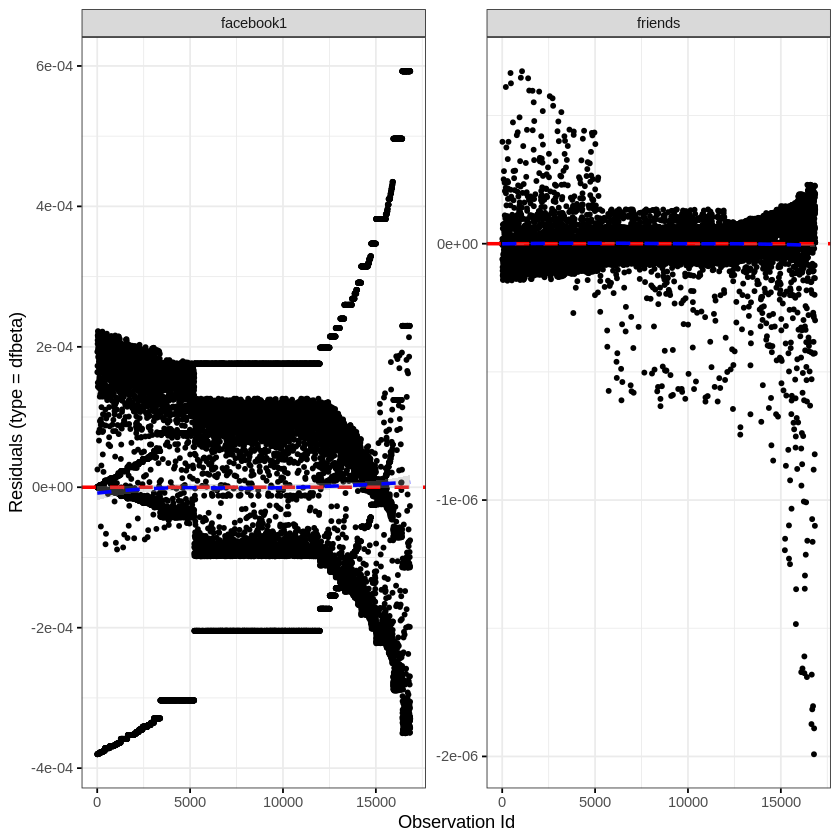

In [ ]:
options(repr.plot.width = 15, repr.plot.height = 7)
ggcoxdiagnostics(m4, type = "dfbeta",
                 linear.predictions = FALSE, ggtheme = theme_bw())

## Resíduos

In [ ]:
residuals.coxph(m7, type = 'scaledsch')
cox.zph(m7, transform = 'identity')
par(mfrow = c(2,4))
plot(cox.zph(m7))

ERROR: ignored